In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt
from qutip.qip.circuit import Gate
from qutip.qip.circuit import QubitCircuit, Gate
from scipy.optimize import minimize
from scipy.fft import fft, ifft, fftfreq, fftshift


import scipy.constants as cst

import sys
sys.path.append('/Users/sebastien/Documents/Code/QRAM/qutip_sims')

from PulseSequence import PulseSequence
from QSwitch import QSwitch

%matplotlib widget
%config InlineBackend.figure_format = 'svg'

style.use('default')
plt.rcParams['figure.figsize'] = [9.7, 6]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# scq.settings.PROGRESSBAR_DISABLED = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
hbar = cst.hbar
h = cst.h
qe = cst.e
red_flux_quant = hbar/2/qe 

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

# Set qubit parameters

In [7]:
qubit_freqs = None
alphas = None


EJs = None
ECs = None


rotating_frame = False


qubit_eg = np.array([4116.60193514429,3450.456887958334, 4766.561902541384, 4381.086137747587])*1e-3
qubit_ef = np.array([3890.5466932677664,3349.983151894969, 4576.680453599131,4210.642810651382])*1e-3

alphas = (qubit_ef - qubit_eg)

gs = np.zeros((4, 4))
gs[0, 1] = 53.81744103399963e-3
gs[1, 2] = 55.95274071800953e-3
gs[1, 3] = 44.5514225071792e-3
gs[0, 2] = 4.324246873301848e-3
gs[0, 3] = 2.3034231276846207e-3
gs[2, 3] = 6.286079155406997e-3

gs = gs + gs.T

T1_eg = np.array([56.986352053917784, 85.60426751127089, 45.27317227359091, 51.26303063231619])*1e3
T1_ef = np.array([20, 20, 20, 20])*1e3

T2_eg = np.array([45.903071070836795, 56.380561904871904, 46.5, 24.674137658175617])*1e3
T2_ef = np.array([20, 20, 20, 20])*1e3

decay_rate_eg = 1/T1_eg
decay_rate_ef = 1/T1_ef

dephasing_rate_eg = 1/T2_eg - decay_rate_eg/2
dephasing_rate_ef = 1/T2_ef - decay_rate_ef/2



crosstalk = 0



In [8]:
cutoffs = [3, 3, 4, 4]
isCavity = [False, False, False, False]



qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    qubit_freqs=qubit_eg,
    alphas=alphas,
    cutoffs=cutoffs,
    isCavity=isCavity,
    crosstalk=crosstalk
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('qubit freqs (GHz)', *qubit_freqs)
print('alphas (GHz)', *alphas)
print('aprox sideband freqs (GHz)', (2*qubit_freqs[2] + alphas[2] - qubit_freqs[1], 2*qubit_freqs[3] + alphas[3] - qubit_freqs[1]))
# print([qram.get_base_wd('ggeg', 'gfgg')/2/np.pi])


# print('capacitances (fF)', *(qe**2/(2*h*np.array(ECs)*1e9)*1e15))
# print('lumped L (nH)', *(red_flux_quant**2/h/np.array(EJs)))

qubit freqs (GHz) 4.11660193514429 3.450456887958334 4.766561902541384 4.3810861377475865
alphas (GHz) -0.22605524187652382 -0.10047373606336496 -0.1898814489422529 -0.17044332709620402
aprox sideband freqs (GHz) (5.892785468182181, 5.141272060440636)


In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def show_mat_2d(mat, ax, title, labels, cmax=1, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title)
    plt.imshow(np.real(mat), cmap='RdBu')
    # hinton(np.real(mat), xlabels=labels, ylabels=labels)
    plt.xticks(np.arange(len(mat)), labels,rotation='vertical',verticalalignment='top')
    plt.yticks(np.arange(len(mat)), labels)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 2), ha="center", va="center", color="w", size=11)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)
    plt.clim(vmin=-cmax, vmax=cmax)
    plt.tight_layout()
    if show: plt.show()

def show_plot_rho_2d(rho_test, rho_id=None, title='', cmax=None, savetitle=None, figsize=(15, 15)):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    if savetitle is not None: plt.style.use('dark_background')

    cutoffs = rho_test.dims[0]
    print(len(cutoffs))

    if len(cutoffs) == 4:
        labels = [f'$|{qram.level_nums_to_name([i, j, k, l])}\\rangle$' for i in range(2) for j in range(2) for k in range(2) for l in range(2)]
    elif len(cutoffs) == 3:
        labels = [f'$|{qram.level_nums_to_name([i, j, k])}\\rangle$' for i in range(2) for j in range(2) for k in range(2)]
    elif len(cutoffs) == 2:
        labels = [f'$|{qram.level_nums_to_name([i, j])}\\rangle$' for i in range(2) for j in range(2)]
    else:
        labels = [f'$|{qram.level_nums_to_name([i])}\\rangle$' for i in range(2)]
    fig, ax = plt.subplots(2, 1, figsize=figsize)


    plt.suptitle(title, fontsize=18)
    if cmax is None: cmax = np.max(np.abs(np.array([np.real(rho_test), np.imag(rho_test), np.real(rho_id), np.imag(rho_id)])))
    show_mat_2d(np.real(rho_test), ax=ax[0], title="Re[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_test), ax=ax[1], title="Im[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show=False)
    plt.tight_layout()

    if savetitle is not None:
        plt.savefig(savetitle, format='png', bbox_inches='tight', transparent = True)
    
    plt.show()

# SWEEP the Q1-Q3 swap versus amplitude

In [11]:
psi0 = (qram.state('gegg') + qram.state('eegg')).unit()
phase_13 = 0 
amp_vec_13 = np.linspace(0.08, 0.15, 15)

prob_eggg_tab = np.zeros(len(amp_vec_13))
prob_eggf_tab = np.zeros(len(amp_vec_13))
prob_egge_tab = np.zeros(len(amp_vec_13))
prob_gegg_tab = np.zeros(len(amp_vec_13))
prob_ggge_tab = np.zeros(len(amp_vec_13))



t_vec_13 = np.zeros(len(amp_vec_13))
w_vec_13 = np.zeros(len(amp_vec_13))

In [13]:
for k in tqdm(range(len(amp_vec_13))):

    seq = PulseSequence(start_time=0)
    amp_swap = amp_vec_13[k]
    wd = qram.get_wd('eggf', 'eegg', amp=amp_swap, drive_qubit=3, verbose=False)
    tp = qram.get_Tpi(wd =wd,  state1='eggf', state2='eegg', amp=amp_swap, drive_qubit=3)
    qram.add_sequential_pi_pulse(seq, 'eggf', 'eegg', amp_swap, drive_qubit=3, phase=phase_13, type='const', wd=wd, t_rise=1, t_pulse=tp)

    amp = 0.03
    pi3_e = qram.get_wd('eggf', 'egge', amp=amp, drive_qubit=3, verbose=False)
    pi3_g = qram.get_wd('gggf', 'ggge', amp=amp, drive_qubit=3, verbose=False)
    pi3 = np.average([pi3_e, pi3_g])
    pi_right = qram.add_sequential_pi_pulse(seq, 'gggf', 'ggge', drive_qubit=3, amp=amp, phase=0, type='gauss', t_offset=1, wd=pi3)

    tf = np.max(seq.get_pulse_lengths())
    tf = seq.time
    times = np.linspace(0, tf + 10, 2000)
    result = qram.evolve(psi0, seq, times, c_ops=None, nsteps=8000, progress=False)
    prob_eggg_tab[k] = np.abs(qram.state('eggg').overlap(result[-1]))**2
    prob_eggf_tab[k] = np.abs(qram.state('eggf').overlap(result[-1]))**2
    prob_egge_tab[k] = np.abs(qram.state('egge').overlap(result[-1]))**2
    prob_gegg_tab[k] = np.abs(qram.state('gegg').overlap(result[-1]))**2
    prob_ggge_tab[k] = np.abs(qram.state('ggge').overlap(result[-1]))**2

    
    t_vec_13[k] = tp
    w_vec_13[k] = wd


  0%|          | 0/15 [00:00<?, ?it/s]

1
One photon transition
Two qubit gate
hello
1
One photon transition
One qubit gate
1
One photon transition
One qubit gate


  7%|▋         | 1/15 [00:45<10:34, 45.34s/it]

1
One photon transition
Two qubit gate
hello
1
One photon transition
One qubit gate


  7%|▋         | 1/15 [01:04<15:08, 64.88s/it]


KeyboardInterrupt: 

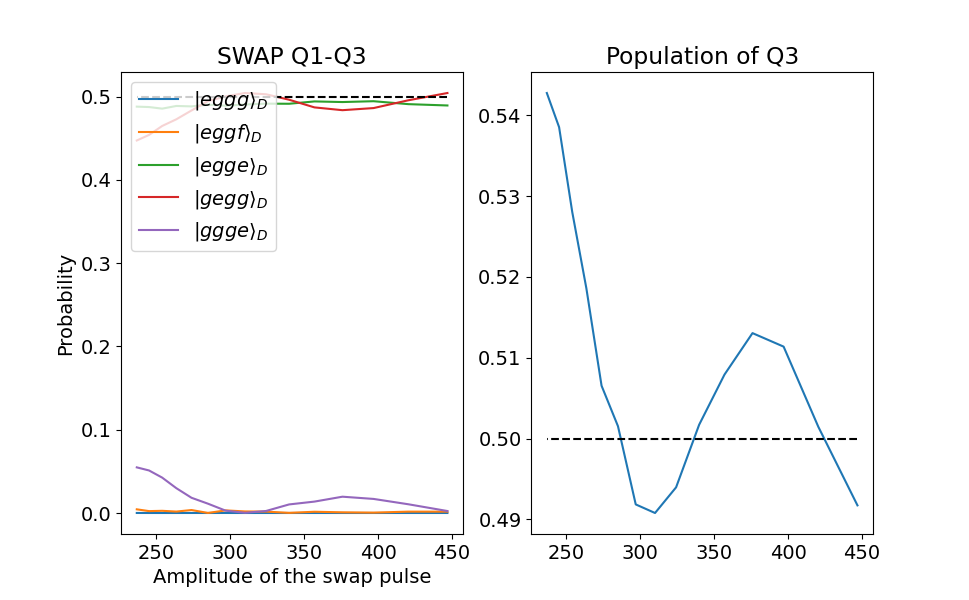

In [ ]:
# plot the probability of the different states as a function of the amplitude of the swap pulse

fig, ax = plt.subplots(1, 2)

ax[0].plot(t_vec_13, prob_eggg_tab, label=r'$|eggg\rangle_D$')
ax[0].plot(t_vec_13, prob_eggf_tab, label=r'$|eggf\rangle_D$')
ax[0].plot(t_vec_13, prob_egge_tab, label=r'$|egge\rangle_D$')
ax[0].plot(t_vec_13, prob_gegg_tab, label=r'$|gegg\rangle_D$')
ax[0].plot(t_vec_13, prob_ggge_tab, label=r'$|ggge\rangle_D$')


ax[0].set_xlabel('Amplitude of the swap pulse')
ax[0].set_ylabel('Probability')

ax[0].legend(loc='upper left')

ax[0].hlines(0.5, t_vec_13[0], t_vec_13[-1], linestyles='dashed', colors='black')

# set the figure title 

ax[0].set_title('SWAP Q1-Q3')

ax[1].set_title('Population of Q3')
ax[1].plot(t_vec_13, prob_egge_tab + prob_ggge_tab)
ax[1].hlines(0.5, t_vec_13[0], t_vec_13[-1], linestyles='dashed', colors='black')





In [ ]:
t13_best = 310
# t12_best = 333.55
amp_13_best = amp_vec_13[np.argmin(np.abs(t_vec_13 - t13_best))]
print('best amplitude for the swap pulse', amp_13_best)

best amplitude for the swap pulse 0.08


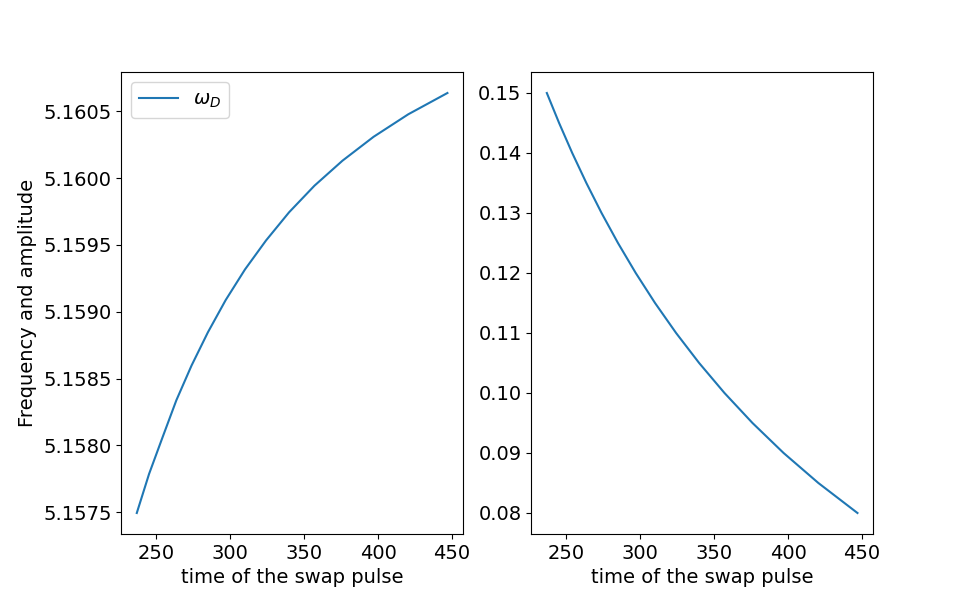

In [ ]:
# plot the amplitude versus pulse time and frequency versus pulse time

fig, ax = plt.subplots(1, 2)

ax[0].plot(t_vec_13, w_vec_13/2/np.pi, label=r'$\omega_D$')
ax[1].plot(t_vec_13, amp_vec_13, label=r'amp_swap')

ax[0].set_xlabel('time of the swap pulse')
ax[1].set_xlabel('time of the swap pulse')

ax[0].set_ylabel('Frequency and amplitude')

ax[0].legend(loc='upper left')

# SWAP between Q1 and Q2 versus amplitude 


In [ ]:
psi0 = (qram.state('eegg') + qram.state('gegg')).unit()

phase_12 = 0
amp_vec_12 = np.linspace(0.08, 0.15, 15)



prob_gegg_tab = np.zeros(len(amp_vec_12))
prob_gggg_tab = np.zeros(len(amp_vec_12))
prob_ggeg_tab = np.zeros(len(amp_vec_12))
prob_ggfg_tab = np.zeros(len(amp_vec_12))
prob_eegg_tab = np.zeros(len(amp_vec_12))
prob_egfg_tab = np.zeros(len(amp_vec_12))
prob_eggg_tab = np.zeros(len(amp_vec_12))
prob_egeg_tab = np.zeros(len(amp_vec_12))

t_vec_12 = np.zeros(len(amp_vec_12))
w_vec_12 = np.zeros(len(amp_vec_12))

In [ ]:
for k in tqdm(range(len(amp_vec_12))):

    seq = PulseSequence(start_time=0)
    amp_swap = amp_vec_12[k]
    wd = qram.get_wd('ggfg', 'gegg', amp=amp_swap, drive_qubit=2, verbose=False)
    tp= qram.get_Tpi(wd=wd, state1='ggfg', state2='gegg', amp=amp_swap, drive_qubit=2)
    qram.add_sequential_pi_pulse(seq, 'ggfg', 'gegg', amp=amp_swap, drive_qubit=2, phase=phase_12, type='const', wd=wd, t_rise=1, t_pulse=tp)
    # amp = 0.03
    # pi3_e = qram.get_wd('egfg', 'egeg', amp=amp, drive_qubit=3, verbose=False)
    # pi3_g = qram.get_wd('ggfg', 'ggeg', amp=amp, drive_qubit=3, verbose=False)
    # pi3 = np.average([pi3_e, pi3_g])
    # pi_right = qram.add_sequential_pi_pulse(seq, 'ggfg', 'ggeg', drive_qubit=2, amp=amp, phase=0, type='gauss', t_offset=1, wd=pi3)


    amp = 0.03
    # pi3_e = qram.get_wd('egfg', 'egeg', amp=amp, drive_qubit=3, verbose=False)
    # pi3_g = qram.get_wd('ggfg', 'ggeg', amp=amp, drive_qubit=3, verbose=False)
    # pi3 = np.average([pi3_e, pi3_g])
    pi_right = qram.add_sequential_pi_pulse(seq, 'ggfg', 'ggeg', drive_qubit=2, amp=amp, phase=0, type='gauss', t_offset=1)




    tf = np.max(seq.get_pulse_lengths())
    tf = seq.time
    times = np.linspace(0, tf + 10, 2000)
    result = qram.evolve(psi0, seq, times, c_ops=None, nsteps=8000, progress=False)
    t_vec_12[k] = tp
    w_vec_12[k] = wd

    prob_gegg_tab[k] = np.abs(qram.state('gegg').overlap(result[-1]))**2
    prob_gggg_tab[k] = np.abs(qram.state('gggg').overlap(result[-1]))**2
    prob_ggeg_tab[k] = np.abs(qram.state('ggeg').overlap(result[-1]))**2
    prob_ggfg_tab[k] = np.abs(qram.state('ggfg').overlap(result[-1]))**2
    prob_eegg_tab[k] = np.abs(qram.state('eegg').overlap(result[-1]))**2
    prob_egfg_tab[k] = np.abs(qram.state('egfg').overlap(result[-1]))**2
    prob_eggg_tab[k] = np.abs(qram.state('eggg').overlap(result[-1]))**2
    prob_egeg_tab[k] = np.abs(qram.state('egeg').overlap(result[-1]))**2


  0%|          | 0/15 [00:00<?, ?it/s]

1
One photon transition
Two qubit gate
hello
1
One photon transition
One qubit gate
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.01254274803877986
        x: [ 2.880e+01]
      nit: 2
      jac: [ 2.912e-05]
     nfev: 8
     njev: 4
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
final drive freq (GHz) 28.79631448598737
28.79631448598737


  7%|▋         | 1/15 [00:32<07:37, 32.69s/it]

1
One photon transition
Two qubit gate
hello
1
One photon transition
One qubit gate
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.01254274803877986
        x: [ 2.880e+01]
      nit: 2
      jac: [ 2.912e-05]
     nfev: 8
     njev: 4
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
final drive freq (GHz) 28.79631448598737
28.79631448598737


 13%|█▎        | 2/15 [01:05<07:02, 32.48s/it]

1
One photon transition
Two qubit gate
hello
1
One photon transition
One qubit gate
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.01254274803877986
        x: [ 2.880e+01]
      nit: 2
      jac: [ 2.912e-05]
     nfev: 8
     njev: 4
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
final drive freq (GHz) 28.79631448598737
28.79631448598737


 20%|██        | 3/15 [01:38<06:37, 33.14s/it]

1
One photon transition
Two qubit gate
hello
1
One photon transition
One qubit gate
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.01254274803877986
        x: [ 2.880e+01]
      nit: 2
      jac: [ 2.912e-05]
     nfev: 8
     njev: 4
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
final drive freq (GHz) 28.79631448598737
28.79631448598737


 27%|██▋       | 4/15 [02:11<06:02, 32.98s/it]

1
One photon transition
Two qubit gate
hello
1
One photon transition
One qubit gate
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.01254274803877986
        x: [ 2.880e+01]
      nit: 2
      jac: [ 2.912e-05]
     nfev: 8
     njev: 4
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
final drive freq (GHz) 28.79631448598737
28.79631448598737


 33%|███▎      | 5/15 [02:45<05:31, 33.15s/it]

1
One photon transition
Two qubit gate
hello
1
One photon transition
One qubit gate
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.01254274803877986
        x: [ 2.880e+01]
      nit: 2
      jac: [ 2.912e-05]
     nfev: 8
     njev: 4
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
final drive freq (GHz) 28.79631448598737
28.79631448598737


 40%|████      | 6/15 [03:16<04:51, 32.42s/it]

1
One photon transition
Two qubit gate
hello
1
One photon transition
One qubit gate
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.01254274803877986
        x: [ 2.880e+01]
      nit: 2
      jac: [ 2.912e-05]
     nfev: 8
     njev: 4
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
final drive freq (GHz) 28.79631448598737
28.79631448598737


 47%|████▋     | 7/15 [03:47<04:17, 32.16s/it]

1
One photon transition
Two qubit gate
hello
1
One photon transition
One qubit gate
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.01254274803877986
        x: [ 2.880e+01]
      nit: 2
      jac: [ 2.912e-05]
     nfev: 8
     njev: 4
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
final drive freq (GHz) 28.79631448598737
28.79631448598737


 53%|█████▎    | 8/15 [04:22<03:51, 33.12s/it]

1
One photon transition
Two qubit gate
hello
1
One photon transition
One qubit gate
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.01254274803877986
        x: [ 2.880e+01]
      nit: 2
      jac: [ 2.912e-05]
     nfev: 8
     njev: 4
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
final drive freq (GHz) 28.79631448598737
28.79631448598737


 60%|██████    | 9/15 [04:57<03:22, 33.69s/it]

1
One photon transition
Two qubit gate
hello
1
One photon transition
One qubit gate
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.01254274803877986
        x: [ 2.880e+01]
      nit: 2
      jac: [ 2.912e-05]
     nfev: 8
     njev: 4
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
final drive freq (GHz) 28.79631448598737
28.79631448598737


 67%|██████▋   | 10/15 [05:28<02:44, 32.84s/it]

1
One photon transition
Two qubit gate
hello
1
One photon transition
One qubit gate
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.01254274803877986
        x: [ 2.880e+01]
      nit: 2
      jac: [ 2.912e-05]
     nfev: 8
     njev: 4
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
final drive freq (GHz) 28.79631448598737
28.79631448598737


 73%|███████▎  | 11/15 [05:59<02:08, 32.21s/it]

1
One photon transition
Two qubit gate
hello
1
One photon transition
One qubit gate
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.01254274803877986
        x: [ 2.880e+01]
      nit: 2
      jac: [ 2.912e-05]
     nfev: 8
     njev: 4
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
final drive freq (GHz) 28.79631448598737
28.79631448598737


 80%|████████  | 12/15 [06:28<01:33, 31.13s/it]

1
One photon transition
Two qubit gate
hello
1
One photon transition
One qubit gate
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.01254274803877986
        x: [ 2.880e+01]
      nit: 2
      jac: [ 2.912e-05]
     nfev: 8
     njev: 4
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
final drive freq (GHz) 28.79631448598737
28.79631448598737


 87%|████████▋ | 13/15 [06:54<00:59, 29.74s/it]

1
One photon transition
Two qubit gate
hello
1
One photon transition
One qubit gate
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.01254274803877986
        x: [ 2.880e+01]
      nit: 2
      jac: [ 2.912e-05]
     nfev: 8
     njev: 4
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
final drive freq (GHz) 28.79631448598737
28.79631448598737


 93%|█████████▎| 14/15 [07:21<00:28, 28.71s/it]

1
One photon transition
Two qubit gate
hello
1
One photon transition
One qubit gate
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.01254274803877986
        x: [ 2.880e+01]
      nit: 2
      jac: [ 2.912e-05]
     nfev: 8
     njev: 4
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
final drive freq (GHz) 28.79631448598737
28.79631448598737


100%|██████████| 15/15 [07:49<00:00, 31.29s/it]


Text(0.5, 0, 'Time (ns)')

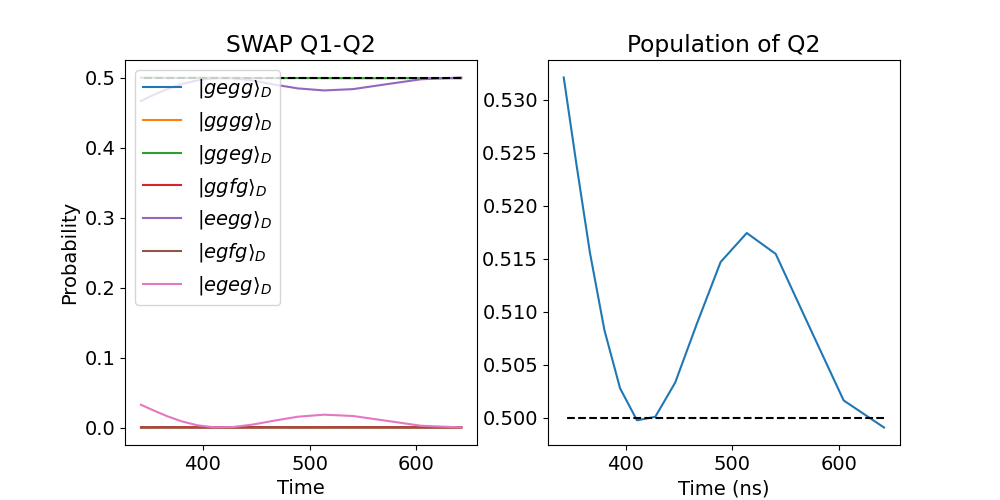

In [ ]:
#  plot the probability of the different states as a function of the amplitude of the swap pulse

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(t_vec_12, prob_gegg_tab, label=r'$|gegg\rangle_D$')
ax[0].plot(t_vec_12, prob_gggg_tab, label=r'$|gggg\rangle_D$')
ax[0].plot(t_vec_12, prob_ggeg_tab, label=r'$|ggeg\rangle_D$')
ax[0].plot(t_vec_12, prob_ggfg_tab, label=r'$|ggfg\rangle_D$')
ax[0].plot(t_vec_12, prob_eegg_tab, label=r'$|eegg\rangle_D$')
ax[0].plot(t_vec_12, prob_egfg_tab, label=r'$|egfg\rangle_D$')
ax[0].plot(t_vec_12, prob_egeg_tab, label=r'$|egeg\rangle_D$')


ax[0].set_xlabel('Time')
ax[0].set_ylabel('Probability')
ax[0].legend(loc='upper left')

# add an horizontale line at 0.5

ax[0].hlines(0.5, t_vec_12[0], t_vec_12[-1], linestyles='dashed', colors='black')
ax[0].set_title('SWAP Q1-Q2')

ax[1].set_title('Population of Q2')
ax[1].plot(t_vec_12, prob_ggeg_tab + prob_egeg_tab)
ax[1].hlines(0.5, t_vec_12[0], t_vec_12[-1], linestyles='dashed', colors='black')

ax[1].set_xlabel('Time (ns)')




In [ ]:
t12_best = 420
amp_12_best = amp_vec_12[np.argmin(np.abs(t_vec_12 - t12_best))]
print('best amplitude for the swap pulse', amp_12_best)

best amplitude for the swap pulse 0.08


## Optimize the SWAP gate between Q1 and Q3 with the pulse on Q2

In [ ]:
psi0 = (qram.state('gegg') + qram.state('eegg')).unit()
phase_13 = 0 
amp_vec_13 = amp_13_best*np.linspace(0.5, 1.1, 30)


prob_gegg_tab = np.zeros(len(amp_vec_13))
prob_ggeg_tab = np.zeros(len(amp_vec_13))
prob_eegg_tab = np.zeros(len(amp_vec_13))
prob_egeg_tab = np.zeros(len(amp_vec_13))
prob_egge_tab = np.zeros(len(amp_vec_13))
prob_ggge_tab = np.zeros(len(amp_vec_13))




t_vec_13 = np.zeros(len(amp_vec_13))
w_vec_13 = np.zeros(len(amp_vec_13))

In [ ]:
t12 = qram.get_Tpi(wd =wd,  state1='ggfg', state2='gegg', amp=amp_12_best, drive_qubit=2)
w12 = qram.get_wd('ggfg', 'gegg', amp=amp_12_best, drive_qubit=2, verbose=False)

amp = 0.03
pi3_e = qram.get_wd('eggf', 'egge', amp=amp, drive_qubit=3, verbose=False)
pi3_g = qram.get_wd('gggf', 'ggge', amp=amp, drive_qubit=3, verbose=False)
pi3 = np.average([pi3_e, pi3_g])
pi2 = qram.get_wd('ggfg', 'ggeg', amp=amp, drive_qubit=2, verbose=False)

for k in tqdm(range(len(amp_vec_13))):

    seq = PulseSequence(start_time=0)
    amp_swap = amp_vec_13[k]
    wd = qram.get_wd('eggf', 'eegg', amp=amp_swap, drive_qubit=3, verbose=False)
    tp = qram.get_Tpi(wd =wd,  state1='eggf', state2='eegg', amp=amp_swap, drive_qubit=3)

    if tp< t12:
        qram.add_sequential_pi_pulse(seq, 'eggf', 'eegg', amp_swap, drive_qubit=3, phase=phase_13, type='const', wd=wd, t_rise=1, t_pulse=tp)
        qram.add_sequential_pi_pulse(seq, 'ggfg', 'gegg', amp=amp_12_best, drive_qubit=2, phase=phase_12,
                                  type='const', wd=w12, t_rise=1, t_pulse=t12, t_offset=-tp)
    else:
        qram.add_sequential_pi_pulse(seq, 'ggfg', 'gegg', amp=amp_12_best, drive_qubit=2, phase=phase_12,
                                  type='const', wd=w12, t_rise=1, t_pulse=t12)
        qram.add_sequential_pi_pulse(seq, 'eggf', 'eegg', amp_swap, drive_qubit=3, phase=phase_13, type='const', wd=wd, t_rise=1, t_pulse=tp, t_offset=-t12)


    pi_right = qram.add_sequential_pi_pulse(seq, 'gggf', 'ggge', drive_qubit=3, amp=amp, phase=0, type='gauss', t_offset=1, wd=pi3)
    pi_left = qram.add_sequential_pi_pulse(seq, 'ggfg', 'ggeg', drive_qubit=2, amp=amp, phase=0, type='gauss', t_offset=1, wd=pi2)

    tf = np.max(seq.get_pulse_lengths())
    tf = seq.time
    times = np.linspace(0, tf + 10, 2000)
    result = qram.evolve(psi0, seq, times, c_ops=None, nsteps=8000, progress=False)
    prob_gegg_tab[k] = np.abs(qram.state('gegg').overlap(result[-1]))**2
    prob_ggeg_tab[k] = np.abs(qram.state('ggeg').overlap(result[-1]))**2
    prob_eegg_tab[k] = np.abs(qram.state('eegg').overlap(result[-1]))**2
    prob_egeg_tab[k] = np.abs(qram.state('egeg').overlap(result[-1]))**2
    prob_egge_tab[k] = np.abs(qram.state('egge').overlap(result[-1]))**2
    prob_ggge_tab[k] = np.abs(qram.state('ggge').overlap(result[-1]))**2

    t_vec_13[k] = tp
    w_vec_13[k] = wd


1
One photon transition
Two qubit gate
hello
1
One photon transition
One qubit gate
1
One photon transition
One qubit gate
1
One photon transition
One qubit gate


  0%|          | 0/30 [00:00<?, ?it/s]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


  3%|▎         | 1/30 [00:49<23:51, 49.35s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


  7%|▋         | 2/30 [01:37<22:48, 48.87s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 10%|█         | 3/30 [02:25<21:47, 48.42s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 13%|█▎        | 4/30 [03:13<20:46, 47.95s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 17%|█▋        | 5/30 [03:59<19:47, 47.50s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 20%|██        | 6/30 [04:45<18:48, 47.02s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 23%|██▎       | 7/30 [05:32<18:00, 46.98s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 27%|██▋       | 8/30 [06:22<17:30, 47.77s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 30%|███       | 9/30 [07:11<16:50, 48.14s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 33%|███▎      | 10/30 [07:59<16:04, 48.22s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 37%|███▋      | 11/30 [08:46<15:11, 47.98s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 40%|████      | 12/30 [09:32<14:11, 47.33s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 43%|████▎     | 13/30 [10:15<13:02, 46.03s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 47%|████▋     | 14/30 [10:59<12:07, 45.46s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 50%|█████     | 15/30 [11:47<11:29, 45.99s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 53%|█████▎    | 16/30 [12:32<10:40, 45.78s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 57%|█████▋    | 17/30 [13:13<09:35, 44.25s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 60%|██████    | 18/30 [13:58<08:53, 44.47s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 63%|██████▎   | 19/30 [14:39<07:57, 43.38s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 67%|██████▋   | 20/30 [15:23<07:16, 43.69s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 70%|███████   | 21/30 [16:10<06:42, 44.73s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 73%|███████▎  | 22/30 [16:58<06:06, 45.78s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 77%|███████▋  | 23/30 [17:45<05:22, 46.13s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 80%|████████  | 24/30 [18:31<04:36, 46.08s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 83%|████████▎ | 25/30 [19:21<03:56, 47.28s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 87%|████████▋ | 26/30 [20:11<03:12, 48.08s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 90%|█████████ | 27/30 [21:01<02:26, 48.68s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 93%|█████████▎| 28/30 [21:45<01:34, 47.07s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


 97%|█████████▋| 29/30 [22:30<00:46, 46.67s/it]

1
One photon transition
Two qubit gate
hello
26.492911130537784
28.79631448598737


100%|██████████| 30/30 [23:14<00:00, 46.47s/it]


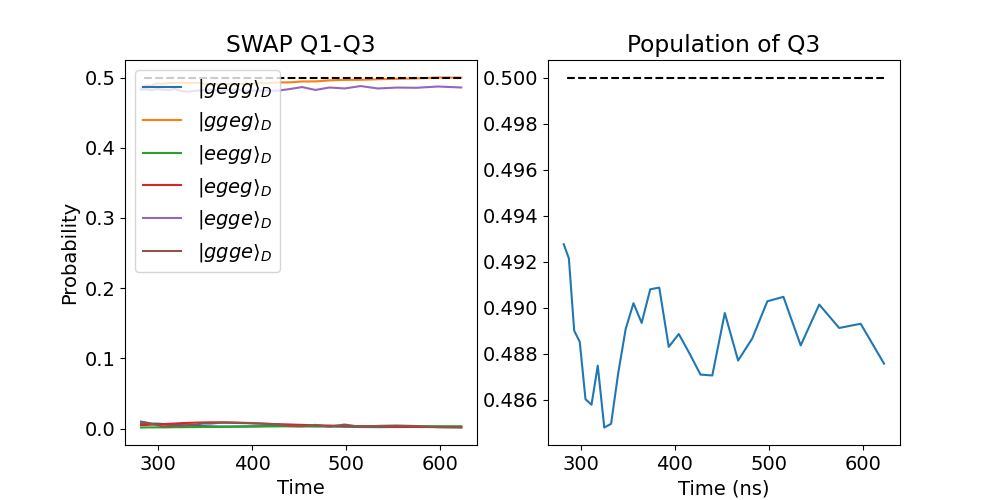

In [ ]:
#  plot the probability of the different states as a function of the amplitude of the swap pulse

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(t_vec_13, prob_gegg_tab, label=r'$|gegg\rangle_D$')
ax[0].plot(t_vec_13, prob_ggeg_tab, label=r'$|ggeg\rangle_D$')
ax[0].plot(t_vec_13, prob_eegg_tab, label=r'$|eegg\rangle_D$')
ax[0].plot(t_vec_13, prob_egeg_tab, label=r'$|egeg\rangle_D$')
ax[0].plot(t_vec_13, prob_egge_tab, label=r'$|egge\rangle_D$')
ax[0].plot(t_vec_13, prob_ggge_tab, label=r'$|ggge\rangle_D$')

ax[0].set_xlabel('Time')
ax[0].set_ylabel('Probability')
ax[0].legend(loc='upper left')

# add an horizontale line at 0.5
ax[0].hlines(0.5, t_vec_13[0], t_vec_13[-1], linestyles='dashed', colors='black')

ax[0].set_title('SWAP Q1-Q3')

ax[1].set_title('Population of Q3')
ax[1].plot(t_vec_13, prob_egge_tab + prob_ggge_tab)
ax[1].hlines(0.5, t_vec_13[0], t_vec_13[-1], linestyles='dashed', colors='black')
ax[1].set_xlabel('Time (ns)')

# bigger police font 
plt.rcParams.update({'font.size': 14})

In [ ]:
# t13_opt = 455
t13_opt = 440
# t13_opt = 311
# for 311 amp_13_opt = 0.11460344827586207
# for 440 amp_13_opt= 0.08129310344827585
print('best time for the swap pulse', t13_opt)
amp_13_opt = None
# amp_13_opt = None
if amp_13_opt is None:
    amp_13_opt = amp_vec_13[np.argmin(np.abs(t_vec_13 - t13_opt))]
print('best amplitude for the swap pulse', amp_13_opt)

best time for the swap pulse 440
best amplitude for the swap pulse 0.04


# Do the same for Q1 and Q2 with the pulse on Q3

In [ ]:
psi0 = (qram.state('gegg') + qram.state('eegg')).unit()

phase_12 = 0
amp_vec_12 = amp_12_best*np.linspace(0.5, 1.1, 30)

prob_gegg_tab = np.zeros(len(amp_vec_12))
prob_ggeg_tab = np.zeros(len(amp_vec_12))
prob_eegg_tab = np.zeros(len(amp_vec_12))
prob_egeg_tab = np.zeros(len(amp_vec_12))
prob_egge_tab = np.zeros(len(amp_vec_12))
prob_ggge_tab = np.zeros(len(amp_vec_12))


t_vec_12 = np.zeros(len(amp_vec_12))
w_vec_12 = np.zeros(len(amp_vec_12))

In [ ]:
w13 = qram.get_wd('eggf', 'eegg', amp=amp_13_opt, drive_qubit=3, verbose=False)
t13 = qram.get_Tpi(wd =w13,  state1='eggf', state2='eegg', amp=amp_13_opt, drive_qubit=3)
print('t13', t13)
amp = 0.03
pi2 = qram.get_wd('ggfg', 'ggeg', amp=amp, drive_qubit=2, verbose=False)

pi3_e = qram.get_wd('eggf', 'egge', amp=amp, drive_qubit=3, verbose=False)
pi3_g = qram.get_wd('gggf', 'ggge', amp=amp, drive_qubit=3, verbose=False)

pi3 = np.average([pi3_e, pi3_g])



for k in tqdm(range(len(amp_vec_12))):

    seq = PulseSequence(start_time=0)
    amp_swap = amp_vec_12[k]
    wd = qram.get_wd('ggfg', 'gegg', amp=amp_swap, drive_qubit=2, verbose=False)
    tp= qram.get_Tpi(wd=wd, state1='ggfg', state2='gegg', amp=amp_swap, drive_qubit=2)

    if tp< t13:
        qram.add_sequential_pi_pulse(seq, 'ggfg', 'gegg', amp=amp_swap, drive_qubit=2, phase=phase_12, type='const', wd=wd, t_rise=1, t_pulse=tp)
        qram.add_sequential_pi_pulse(seq, 'eggf', 'eegg', amp=amp_13_opt, drive_qubit=3, phase=phase_13,
                                  type='const', wd=w13, t_rise=1, t_pulse=t13, t_offset=-tp)
    else:
        qram.add_sequential_pi_pulse(seq, 'eggf', 'eegg', amp=amp_13_opt, drive_qubit=3, phase=phase_13,
                                  type='const', wd=w13, t_rise=1, t_pulse=t13)
        qram.add_sequential_pi_pulse(seq, 'ggfg', 'gegg', amp=amp_swap, drive_qubit=2, phase=phase_12, type='const', wd=wd, t_rise=1, t_pulse=tp, t_offset=-t13)


    pi_right = qram.add_sequential_pi_pulse(seq, 'ggfg', 'ggeg', drive_qubit=2, amp=amp, phase=0, type='gauss', t_offset=1, wd=pi2)
    pi_left = qram.add_sequential_pi_pulse(seq, 'gggf', 'ggge', drive_qubit=3, amp=amp, phase=0, type='gauss', t_offset=1, wd=pi3)
    tf = np.max(seq.get_pulse_lengths())
    tf = seq.time
    times = np.linspace(0, tf + 10, 2000)
    print(times[-1])
    result = qram.evolve(psi0, seq, times, c_ops=None, nsteps=8000, progress=False)
    t_vec_12[k] = tp
    w_vec_12[k] = wd

    prob_gegg_tab[k] = np.abs(qram.state('gegg').overlap(result[-1]))**2
    prob_ggeg_tab[k] = np.abs(qram.state('ggeg').overlap(result[-1]))**2
    prob_eegg_tab[k] = np.abs(qram.state('eegg').overlap(result[-1]))**2
    prob_egeg_tab[k] = np.abs(qram.state('egeg').overlap(result[-1]))**2
    prob_egge_tab[k] = np.abs(qram.state('egge').overlap(result[-1]))**2
    prob_ggge_tab[k] = np.abs(qram.state('ggge').overlap(result[-1]))**2

1
One photon transition
Two qubit gate
hello
t13 311.2239055421423
1
One photon transition
One qubit gate
1
One photon transition
One qubit gate
1
One photon transition
One qubit gate


  0%|          | 0/30 [00:00<?, ?it/s]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
907.697292060721


  3%|▎         | 1/30 [01:01<29:49, 61.71s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
873.6592286505436


  7%|▋         | 2/30 [01:55<26:42, 57.22s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
842.2218513056083


 10%|█         | 3/30 [02:48<24:55, 55.38s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
813.0981415179712


 13%|█▎        | 4/30 [03:42<23:40, 54.62s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
786.0416733324066


 17%|█▋        | 5/30 [04:35<22:29, 53.98s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
760.8398075952609


 20%|██        | 6/30 [05:27<21:19, 53.30s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
737.3081027810634


 23%|██▎       | 7/30 [06:20<20:29, 53.44s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
715.2857881744819


 27%|██▋       | 8/30 [07:11<19:16, 52.58s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
694.6320863807401


 30%|███       | 9/30 [08:00<17:59, 51.41s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
675.2231797877904


 33%|███▎      | 10/30 [08:48<16:47, 50.39s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
656.9496998127394


 37%|███▋      | 11/30 [09:36<15:44, 49.73s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
639.7150516723034


 40%|████      | 12/30 [10:29<15:10, 50.59s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
623.4328633196232


 43%|████▎     | 13/30 [11:18<14:14, 50.27s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
608.0261726587605


 47%|████▋     | 14/30 [12:11<13:34, 50.91s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
593.4263492922648


 50%|█████     | 15/30 [12:59<12:29, 49.99s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
579.5714015455238


 53%|█████▎    | 16/30 [13:50<11:46, 50.48s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
566.4057609680659


 57%|█████▋    | 17/30 [14:38<10:44, 49.61s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
553.8793837368895


 60%|██████    | 18/30 [15:23<09:38, 48.20s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
541.9464747140895


 63%|██████▎   | 19/30 [16:10<08:46, 47.84s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
530.5659516182017


 67%|██████▋   | 20/30 [16:57<07:57, 47.75s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
519.7003285391858


 70%|███████   | 21/30 [17:44<07:05, 47.30s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
509.3152622215869


 73%|███████▎  | 22/30 [18:28<06:12, 46.54s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
499.37960875453695


 77%|███████▋  | 23/30 [19:22<05:40, 48.65s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
489.86480987329935


 80%|████████  | 24/30 [20:10<04:50, 48.48s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
480.74455649697995


 83%|████████▎ | 25/30 [20:58<04:01, 48.27s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
471.9948787178058


 87%|████████▋ | 26/30 [21:42<03:07, 46.90s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
463.5935254483038


 90%|█████████ | 27/30 [22:25<02:17, 45.82s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
455.5201013757903


 93%|█████████▎| 28/30 [23:08<01:29, 44.99s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
447.7557332642785


 97%|█████████▋| 29/30 [23:51<00:44, 44.37s/it]

1
One photon transition
Two qubit gate
hello
28.79631448598737
26.492911130537784
440.28299926435267


100%|██████████| 30/30 [24:31<00:00, 49.06s/it]


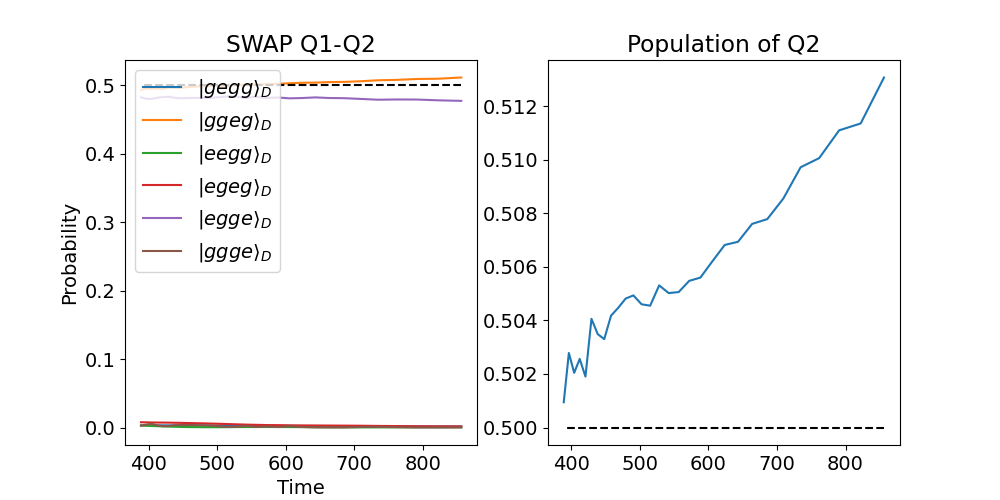

In [ ]:
# plot the probability of the different states as a function of the amplitude of the swap pulse

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].plot(t_vec_12, prob_gegg_tab, label=r'$|gegg\rangle_D$')
ax[0].plot(t_vec_12, prob_ggeg_tab, label=r'$|ggeg\rangle_D$')
ax[0].plot(t_vec_12, prob_eegg_tab, label=r'$|eegg\rangle_D$')
ax[0].plot(t_vec_12, prob_egeg_tab, label=r'$|egeg\rangle_D$')
ax[0].plot(t_vec_12, prob_egge_tab, label=r'$|egge\rangle_D$')
ax[0].plot(t_vec_12, prob_ggge_tab, label=r'$|ggge\rangle_D$')




# ax[0].plot(t_vec_12, prob_gegg_tab, label=r'$|gegg\rangle_D$')
# ax[0].plot(t_vec_12, prob_ggeg_tab, label=r'$|ggeg\rangle_D$')
# ax[0].plot(t_vec_12, prob_eegg_tab, label=r'$|eegg\rangle_D$')
# ax[0].plot(t_vec_12, prob_egeg_tab, label=r'$|egeg\rangle_D$')
# ax[0].plot(t_vec_12, prob_eggg_tab, label=r'$|eggg\rangle_D$')
# ax[0].plot(t_vec_12, prob_ggge_tab, label=r'$|ggge\rangle_D$')

ax[0].set_xlabel('Time')
ax[0].set_ylabel('Probability')

ax[0].legend(loc='upper left')

# add an horizontale line at 0.5

ax[0].hlines(0.5, t_vec_12[0], t_vec_12[-1], linestyles='dashed', colors='black')
ax[0].set_title('SWAP Q1-Q2')


ax[1].set_title('Population of Q2') 
ax[1].plot(t_vec_12, prob_ggeg_tab + prob_egeg_tab)
ax[1].hlines(0.5, t_vec_12[0], t_vec_12[-1], linestyles='dashed', colors='black')



# bigger police font 
plt.rcParams.update({'font.size': 14})


In [124]:
t12_opt = 416

print('best time for the swap pulse', t12_opt)
amp_12_opt =None
# amp_12_opt = 0.12455172413793106
if amp_12_opt is None:
    amp_12_opt = amp_vec_12[np.argmin(np.abs(t_vec_12 - t12_opt))]
print('best amplitude for the swap pulse', amp_12_opt)

best time for the swap pulse 416


NameError: name 'amp_vec_12' is not defined

## Creat a input and output state dictionary for the routing

In [14]:
# initial states
gggg  = qram.state('gggg')
eggg = qram.state('eggg')
gegg = qram.state('gegg')
eegg = qram.state('eegg')
pegg = (eegg + gegg).unit()
pggg = (gggg + eggg).unit()
gpgg = (gggg + gegg).unit()
epgg = (eggg + eegg).unit()
ppgg = (pggg + pegg).unit()
psi_init = {'gggg': gggg, 'eggg': eggg, 'gegg': gegg, 'eegg': eegg, '+egg': pegg, '+ggg': pggg, 'g+gg': gpgg, 'e+gg': epgg, '++gg': ppgg}

# final states

gggg_f = qram.state('gggg')
eggg_f = qram.state('eggg')
gegg_f = qram.state('ggeg')
eegg_f = qram.state('egge')
pegg_f = (eegg_f + gegg_f).unit()
pggg_f = (gggg_f + eggg_f).unit()
gpgg_f = (gggg_f + gegg_f).unit()
epgg_f = (eggg_f + eegg_f).unit()
ppgg_f = (pggg_f + pegg_f).unit()
psi_f = {'gggg': gggg_f, 'eggg': eggg_f, 'gegg': gegg_f, 'eegg': eegg_f, '+egg': pegg_f, '+ggg': pggg_f, 'g+gg': gpgg_f, 'e+gg': epgg_f, '++gg': ppgg_f}

### routing protocol 

In [15]:
seq = PulseSequence(start_time=0)

# wd_12 = 37.11093010613139
# wd_13 = 32.42453324156954

# t12 = 415.8058212669294
# t13 = 427.62493324950776

# wd_12 = 37.11093010613139
# wd_13 = 32.42558383637162

# t12 = 415.8058212669294
# t13 = 457.11766448169436


amp_12_opt = 0.12455172413793106
amp_13_opt = 0.08129310344827585

wd_12 = None
wd_13 = None

t12 = None
t13 = None

phase_12 = 0
phase_13 = 0

dead_time_prep = 0
dead_time_tomo = 0

if wd_12 == None:
    wd_12 = qram.get_wd('ggfg', 'gegg', amp=amp_12_opt, drive_qubit=2, verbose=False)
if t12 == None:
    t12 = qram.get_Tpi(wd=wd_12, state1='ggfg', state2='gegg', amp=amp_12_opt, drive_qubit=2)

if wd_13 == None:
    wd_13 = qram.get_wd('eggf', 'eegg', amp=amp_13_opt, drive_qubit=3, verbose=False)
if t13 == None:
    t13 = qram.get_Tpi(wd=wd_13, state1='eggf', state2='eegg', amp=amp_13_opt, drive_qubit=3)


amp_ef = 0.03
amp = 0.03
pi3_e = qram.get_wd('eggf', 'egge', amp=amp_ef, drive_qubit=3, verbose=False)
pi3_g = qram.get_wd('gggf', 'ggge', amp=amp_ef, drive_qubit=3, verbose=False)
pi3 = np.average([pi3_e, pi3_g])
tef3 = qram.get_Tpi(wd=pi3, state1='gggf', state2='ggge', amp=amp_ef, drive_qubit=3,type='gauss')
pi2 = qram.get_wd('ggfg', 'ggeg', amp=amp, drive_qubit=2, verbose=False)
tef2 = qram.get_Tpi(wd=pi2, state1='ggfg', state2='ggeg', amp=amp_ef, drive_qubit=2, type='gauss')


# add the gate to rotate the final state: 

phi_rot = np.array([1.2999693738992248, 2.383277185481912, 1.5166309362157622])

pi0 = qram.get_wd('eggg', 'gggg', amp=amp, drive_qubit=0, verbose=False)
t0 = qram.get_Tpi(wd=pi0, state1='eggg', state2='gggg', amp=amp, drive_qubit=0, type='gauss')

1
One photon transition
Two qubit gate
hello
1
One photon transition
Two qubit gate
hello
1
One photon transition
One qubit gate
1
One photon transition
One qubit gate
1
One photon transition
One qubit gate
1
One photon transition
One qubit gate


In [16]:
print('wd_12', wd_12)
print('t12', t12)
print('wd_13', wd_13)
print('t13', t13)
print('pi3', pi3)
print('pi2', pi2)
print('tef3', tef3)
print('tef2', tef2)
print('pi0', pi0)
print('t0', t0)

wd_12 37.11074523963709
t12 412.0470149281503
wd_13 32.424984795120075
t13 439.7289599009393
pi3 26.49109675668611
pi2 28.79631049922486
tef3 4.947654981256527
tef2 4.938972648397861
pi0 25.903845119402696
t0 6.989272940989117


In [18]:
seq = PulseSequence(start_time=0)

qram.add_sequential_pi_pulse(seq, 'ggfg', 'gegg', amp_12_opt, drive_qubit=2, phase=phase_12, type='const', wd=wd_12, t_rise=1, t_pulse=t12, t_offset=dead_time_prep)
qram.add_sequential_pi_pulse(seq, 'eggf', 'eegg', amp_13_opt, drive_qubit=3, phase=phase_13, type='const', wd=wd_13, t_rise=1, t_pulse=t13, t_offset=-t12)

# add the two pi pulses
qram.add_sequential_pi_pulse(seq, 'eggf', 'egge', drive_qubit=3, amp=amp_ef, phase=0, type='gauss', t_offset=1, wd=pi3, sigma_n=4, t_pulse=tef3)
qram.add_sequential_pi_pulse(seq, 'ggfg', 'ggeg', drive_qubit=2, amp=amp, phase=0, type='gauss', wd=pi2, t_pulse=tef2, sigma_n=4)

# # add the rotation gate on q0

# qram.add_sequential_pi_pulse(seq, 'eggg', 'gggg', drive_qubit=0, amp=amp, phase=-np.pi/2, type='gauss', wd=pi0, t_pulse=t0, sigma_n=5, t_offset=2)
# qram.add_sequential_pi_pulse(seq, 'eggg', 'gggg', drive_qubit=0, amp=amp, phase=-np.pi/2 - phi_rot[0], type='gauss', wd=pi0, t_pulse=t0, sigma_n=5, t_offset=2)

28.79631049922486

### creat a sequence of gates with the preparation pulse if needed

In [22]:
prep_pulse = False

# creat a dictionary linking the initial state and the pulse sequence

if prep_pulse: 
    amp_pi = 0.02
    seq_dict = {}

    for key in psi_init.keys():
        print(key)
        seq_temp = PulseSequence(start_time=0)
        q0_state = key[0]
        q1_state = key[1]

        if q0_state + q1_state != '++':
            if q0_state == 'e':
                qram.add_sequential_pi_pulse(seq_temp, 'gggg', 'eggg', drive_qubit=0, amp=amp_pi, phase=0, type='gauss', sigma_n=5, verbose=False)
                if q1_state == 'e':
                    qram.add_sequential_pi_pulse(seq_temp, 'eggg', 'eegg', drive_qubit=1, amp=amp_pi, phase=0, type='gauss', sigma_n=5, verbose=False)
                if q1_state == '+':
                    qram.add_sequential_pi_pulse(seq_temp, 'eggg', 'eegg', drive_qubit=1, amp=amp_pi, phase=0, type='gauss', sigma_n=5, pihalf=True, verbose=False)

        if q0_state == 'g':
            if q1_state == 'e':
                qram.add_sequential_pi_pulse(seq_temp, 'gggg', 'gegg', drive_qubit=1, amp=amp_pi, phase=0, type='gauss', sigma_n=5, verbose=False)
            if q1_state == '+':
                qram.add_sequential_pi_pulse(seq_temp, 'gggg', 'gegg', drive_qubit=1, amp=amp_pi, phase=0, type='gauss', sigma_n=5, pihalf=True, verbose=False)

        if q0_state == '+':
            if q1_state == 'e':
                qram.add_sequential_pi_pulse(seq_temp, 'gggg', 'gegg', drive_qubit=1, amp=amp_pi, phase=0, type='gauss', sigma_n=5, verbose=False)
                qram.add_sequential_pi_pulse(seq_temp, 'gegg', 'eegg', drive_qubit=0, amp=amp_pi, phase=0, type='gauss', sigma_n=5, verbose=False, pihalf=True)
            if q1_state == 'g':
                qram.add_sequential_pi_pulse(seq_temp, 'gggg', 'eggg', drive_qubit=0, amp=amp_pi, phase=0, type='gauss', sigma_n=5, verbose=False, pihalf=True)
            
        if q0_state+q1_state == '++':
            print('ok')

            qram.add_sequential_pi_pulse(seq_temp, 'gggg', 'eggg', drive_qubit=0, amp=amp_pi, phase=0, type='gauss', sigma_n=5, pihalf=True, verbose=False)

            w1 = qram.get_wd('gggg', 'gegg', amp=amp_pi/35, drive_qubit=1, verbose=False)
            w2 = qram.get_wd('eggg', 'eegg', amp=amp_pi/35, drive_qubit=1, verbose=False)
            qram.add_sequential_pi_pulse(seq_temp, 'gggg', 'gegg', drive_qubit=1, amp=amp_pi/35, phase=0, type='gauss', sigma_n=5, wd=w1, pihalf=True, verbose=False)
            qram.add_sequential_pi_pulse(seq_temp, 'eggg', 'eegg', drive_qubit=1, amp=amp_pi/35, phase=0, type='gauss', sigma_n=5, wd=w2, pihalf=True, verbose=False)


        # qram protocol 

        
        qram.add_sequential_pi_pulse(seq_temp, 'ggfg', 'gegg', amp_12_opt, drive_qubit=2, phase=phase_12, type='const', wd=wd_12, t_rise=1, t_pulse=t12, t_offset=dead_time_prep)
        qram.add_sequential_pi_pulse(seq_temp, 'eggf', 'eegg', amp_13_opt, drive_qubit=3, phase=phase_13, type='const', wd=wd_13, t_rise=1, t_pulse=t13, t_offset=-t12)

        # qram.add_sequential_pi_pulse(seq, 'eggf', 'eegg', amp_13_opt, drive_qubit=3, phase=phase_13, type='const', wd=wd_13, t_rise=1, t_pulse=t13)
        # qram.add_sequential_pi_pulse(seq, 'ggfg', 'gegg', amp_12_opt, drive_qubit=2, phase=phase_12, type='const', wd=wd_12, t_rise=1, t_pulse=t12, t_offset=-t13)

        # add the two pi pulses
        qram.add_sequential_pi_pulse(seq_temp, 'eggf', 'egge', drive_qubit=3, amp=amp, phase=0, type='gauss', t_offset=1, wd=pi3, sigma_n=5, t_pulse=tef3)
        qram.add_sequential_pi_pulse(seq_temp, 'ggfg', 'ggeg', drive_qubit=2, amp=amp, phase=0, type='gauss', sigma_n=5, wd=pi2, t_pulse=tef2)

        seq_dict[key] = seq_temp


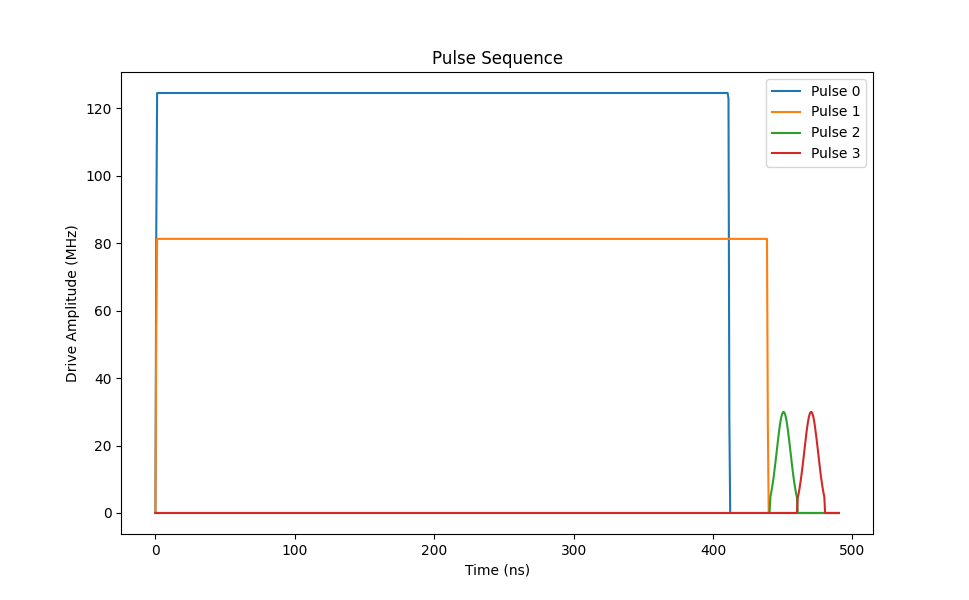

In [19]:
envelope_seq = seq.get_envelope_seq()
pulse_amps = seq.get_pulse_amps()
pulse_lens = seq.get_pulse_lengths()
tf = seq.time
times = np.linspace(0, tf+10, 800)
flat_times = np.array(times).flatten()

figp, axp = plt.subplots(1, 1)

for i in range(len(envelope_seq)):
    axp.plot(flat_times, [pulse_amps[i]*envelope_seq[i](t)/MHz for t in flat_times], label=f'Pulse {i}')
axp.set_xlabel('Time (ns)')
axp.set_ylabel('Drive Amplitude (MHz)')
axp.set_title('Pulse Sequence')
axp.legend()

In [20]:
# eggg = qram.state('eggg')
# gegg = qram.state('gegg')
# ggeg = qram.state('ggeg')
# ggge = qram.state('ggge')


# w_q0 = eggg.dag()*qram.H*eggg/2/np.pi
# w_q1 = gegg.dag()*qram.H*gegg/2/np.pi
# w_q2 = ggeg.dag()*qram.H*ggeg/2/np.pi
# w_q3 = ggge.dag()*qram.H*ggge/2/np.pi


# H_rot = 2*np.pi*w_q0*qram.a_ops[0].dag()*qram.a_ops[0]
# H_rot += 2*np.pi*w_q1*qram.a_ops[1].dag()*qram.a_ops[1]
# H_rot += 2*np.pi*w_q2*qram.a_ops[2].dag()*qram.a_ops[2]
# H_rot += 2*np.pi*w_q3*qram.a_ops[3].dag()*qram.a_ops[3]

# e_disp, eig_disp = H_rot.eigenstates()



H_rot = qram.H*0

for i in range(cutoffs[0]):
    for j in range(cutoffs[1]):
        for k in range(cutoffs[2]):
            for l in range(cutoffs[3]):
                psi_ids = [i, j, k, l]
                psi = qram.level_nums_to_name(psi_ids)
                psi_i = qram.level_nums_to_name([i,0,0,0])
                psi_j = qram.level_nums_to_name([0,j,0,0])
                psi_k = qram.level_nums_to_name([0,0,k,0])
                psi_l = qram.level_nums_to_name([0,0,0,l])
                ket = qram.state(psi)
                ket_i = qram.state(psi_i)
                ket_j = qram.state(psi_j)
                ket_k = qram.state(psi_k)
                ket_l = qram.state(psi_l)
                wi = ket_i.dag()*qram.H*ket_i/2/np.pi
                wj = ket_j.dag()*qram.H*ket_j/2/np.pi
                wk = ket_k.dag()*qram.H*ket_k/2/np.pi
                wl = ket_l.dag()*qram.H*ket_l/2/np.pi
                H_rot += (wi + wj + wk)*ket*ket.dag()

e_disp, eig_disp = H_rot.eigenstates()




In [23]:
state_plot = '+egg'

if prep_pulse:
    psi0 = psi_init['gggg']
    tf = seq_dict[state_plot].time
    times = np.linspace(0, tf+10, 800)
    result = qram.evolve(psi0, seq_dict[state_plot], times, c_ops=None, nsteps=8000, progress=False)
else: 
    psi0 = psi_init[state_plot]
    result = qram.evolve(psi0, seq, times, c_ops=None, nsteps=8000, progress=False)


if rotating_frame:

    result_rot = [0*result[i_t] for i_t in range(len(times))]
    # evals, evecs = qram.esys

    for i_t, t in enumerate(tqdm(times)):
        # for eval, evec in zip(evals, evecs):
        for E, eig in zip(e_disp, eig_disp):
            result_rot[i_t] += np.exp(1j*E*t) * eig.overlap(result[i_t]) * eig

else:

    result_rot = result

# pick up the relevant states for the protocol 

psi_plot = []

for t in [0, 2*len(times)//3,-1]:
    for i in range(cutoffs[0]):
        for j in range(cutoffs[1]):
            for k in range(cutoffs[2]):
                for l in range(cutoffs[3]):
                    psi_ids = [i, j, k, l]
                    psi = qram.level_nums_to_name(psi_ids)
                    # print(psi)
                    ov = np.abs(result_rot[t].overlap(qram.state(psi)))
                    if ov > 0.05:
                        print(psi, ov)
                        psi_plot.append(psi)

psi_plot = list(set(psi_plot))

gegg 0.7071067811865476
eegg 0.7071067811865475
ggeg 0.05131773459908577
ggfg 0.6610958086686577
gghg 0.06492013272267153
gegg 0.23302636793406228
eggf 0.6351353686612426
egfg 0.12328309037763109
eegg 0.2729535290397089
ggge 0.07090456609904561
ggeg 0.7044394815869588
egge 0.6938954311181135
eggf 0.052425666918251165
egeg 0.07823951586699479
eegg 0.060810216034831


Quantum object: dims = [[3, 3, 4, 4], [1, 1, 1, 1]], shape = (144, 1), type = ket
Qobj data =
[[ 0.        ]
 [-0.04671663]
 [ 0.        ]
 [ 0.        ]
 [-0.04154095]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.99491907]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.07891737]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0. 

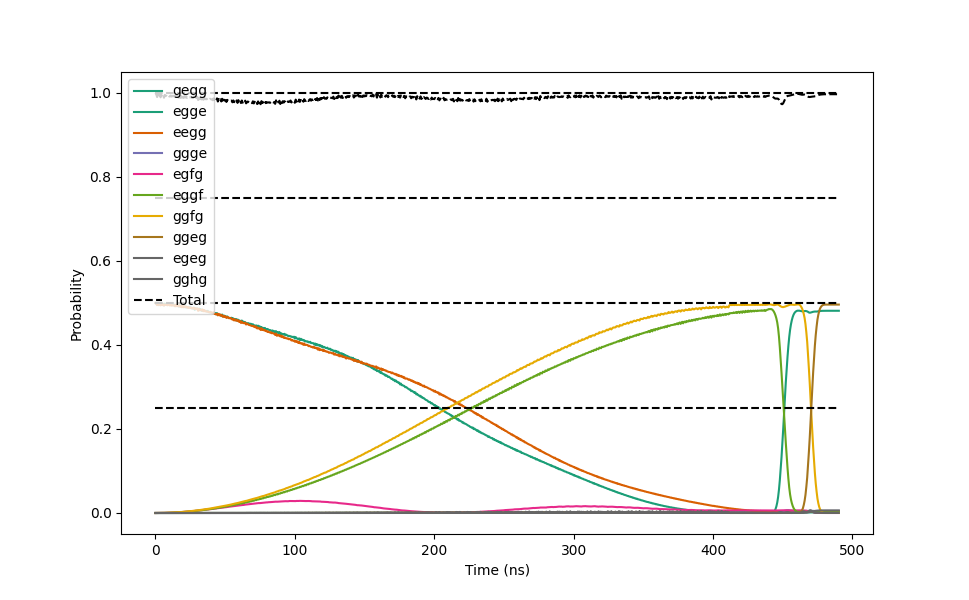

In [24]:
cmap = plt.get_cmap('Dark2')
colors = cmap(np.linspace(0, 1, len(psi_plot)))
figs, axs = plt.subplots(1, 1)

prob_sum = np.zeros(len(times))

for psi in psi_plot:
    state = qram.state(psi)
    prob = [np.abs(state.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_sum += prob

for psi in psi_plot: 
    state = qram.state(psi)
    print(state)
    print(result_rot[0])

    # prob = [np.abs(state.dag()*result_rot[t]*state.full()).flatten() for t in range(len(times))]
    prob = [np.abs(state.overlap(result_rot[t]))**2 for t in range(len(times))]

    axs.plot(times, prob, label=psi, color=colors[psi_plot.index(psi)])

axs.plot(times, prob_sum, label='Total', color='black', linestyle='dashed')

axs.hlines(0.5, 0, times[-1], linestyles='dashed', colors='black')
axs.hlines(1, 0, times[-1], linestyles='dashed', colors='black')
axs.hlines(0.25, 0, times[-1], linestyles='dashed', colors='black')
axs.hlines(0.75, 0, times[-1], linestyles='dashed', colors='black')
axs.set_xlabel('Time (ns)')
axs.set_ylabel('Probability')

axs.legend(loc='upper left')

### Compute the result for all the possible input states

In [25]:
psi_result = {}

for psi in tqdm(psi_init):
    print(psi)
    if prep_pulse:
        psi0 = psi_init['gggg']
        tf = seq_dict[psi].time
        times = np.linspace(0, tf, 800)
        result = qram.evolve(psi0, seq_dict[psi], times, c_ops=None, nsteps=8000, progress=False)
    else: 
        psi0 = psi_init[psi]
        result = qram.evolve(psi_init[psi], seq, times, c_ops=None, nsteps=8000, progress=False)

    evals, evecs = qram.esys
    result_rot = 0*result[-1]
    e_disp, eig_disp
    # for E, eig in zip(evals, evecs):
    for E, eig in zip(e_disp, eig_disp):
        result_rot += np.exp(1j*E*tf) * eig.overlap(result[-1]) * eig


    psi_result[psi] = result_rot

  0%|          | 0/9 [00:00<?, ?it/s]

gggg


 11%|█         | 1/9 [00:08<01:07,  8.43s/it]

eggg


 22%|██▏       | 2/9 [00:14<00:50,  7.20s/it]

gegg


 33%|███▎      | 3/9 [00:20<00:40,  6.68s/it]

eegg


 44%|████▍     | 4/9 [00:27<00:33,  6.79s/it]

+egg


 56%|█████▌    | 5/9 [00:34<00:27,  6.78s/it]

+ggg


 67%|██████▋   | 6/9 [00:40<00:19,  6.62s/it]

g+gg


 78%|███████▊  | 7/9 [00:47<00:12,  6.47s/it]

e+gg


 89%|████████▉ | 8/9 [00:53<00:06,  6.50s/it]

++gg


100%|██████████| 9/9 [01:00<00:00,  6.69s/it]


### define the Z rotations on the 4 qubits

In [26]:
def Z(phi1, phi2, phi3, phi4=None):

    
    r1 = qt.qip.operations.gates.rz(phi1)
    r2 = qt.qip.operations.gates.rz(phi2)
    r3 = qt.qip.operations.gates.rz(phi3)
    if phi4 is not None:
        r4 = qt.qip.operations.gates.rz(phi4)

    if phi4 is not None:
        U = qt.tensor(r1, r2, r3, r4)
    else:
        U = qt.tensor(r1, r2, r3)
    return U

# project on the qubits subspaces

In [27]:
# partial trace on the final states to keep only the qubit subspace

U1 = np.zeros((cutoffs[0], cutoffs[0]))
U2 = np.zeros((cutoffs[1], cutoffs[1]))
U3 = np.zeros((cutoffs[2], cutoffs[2]))
U4 = np.zeros((cutoffs[3], cutoffs[3]))

U1[:2, :2] = qt.qeye(2).full()
U2[:2, :2] = qt.qeye(2).full()
U3[:2, :2] = qt.qeye(2).full()
U4[:2, :2] = qt.qeye(2).full()

U1 = qt.Qobj(U1)
U2 = qt.Qobj(U2)
U3 = qt.Qobj(U3)
U4 = qt.Qobj(U4)

U = qt.tensor(U1, U2, U3, U4).full()

zeros = np.argwhere(np.diag(U) != 0).flatten()

 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_79425/2457070569.py: 8ComplexWarning: Casting complex values to real discards the imaginary part
 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_79425/2457070569.py: 9ComplexWarning: Casting complex values to real discards the imaginary part
 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_79425/2457070569.py: 10ComplexWarning: Casting complex values to real discards the imaginary part
 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_79425/2457070569.py: 11

In [28]:
psi_result_qubit = {}
# psi_result_qubit_rot = {}
psi_f_qubit = {}
# U_best = Z(phi1_vec[max_fid_idx[0]], phi2_vec[max_fid_idx[1]], phi3_vec[max_fid_idx[2]], phi4_vec[max_fid_idx[3]])


for psi in psi_f:
    # psi_rot = U_best*psi_result[psi]
    psi_result_qubit[psi] = psi_result[psi].full()[zeros]
    psi_result_qubit[psi] = qt.Qobj(psi_result_qubit[psi])
    psi_result_qubit[psi].dims = [[2, 2, 2, 2], [1, 1, 1, 1]]
    # psi_result_qubit_rot[psi] = psi_rot.full()[zeros]
    # psi_result_qubit_rot[psi] = qt.Qobj(psi_result_qubit_rot[psi])
    # psi_result_qubit_rot[psi].dims = [[2, 2, 2, 2], [1, 1, 1, 1]]
    psi_f_qubit[psi] = psi_f[psi].full()[zeros]
    psi_f_qubit[psi] = qt.Qobj(psi_f_qubit[psi])
    psi_f_qubit[psi].dims = [[2, 2, 2, 2], [1, 1, 1, 1]]

### Optimize the Z rotations for the ppgg state 

In [29]:
phi1_vec = np.linspace(0, 2*np.pi, 30)
phi2_vec = np.linspace(0, 2*np.pi, 1)
phi3_vec = np.linspace(0, 2*np.pi, 30)
phi4_vec = np.linspace(0, 2*np.pi, 30)

fidelities_ppgg = np.zeros((len(phi1_vec), len(phi2_vec), len(phi3_vec), len(phi4_vec)))
fidelities_epgg = np.zeros((len(phi1_vec), len(phi2_vec), len(phi3_vec), len(phi4_vec)))
fidelities_pegg = np.zeros((len(phi1_vec), len(phi2_vec), len(phi3_vec), len(phi4_vec)))
fidelities_gpgg = np.zeros((len(phi1_vec), len(phi2_vec), len(phi3_vec), len(phi4_vec)))


for i, phi1 in enumerate(tqdm(phi1_vec)):
    for j, phi2 in enumerate(tqdm(phi2_vec)):
        for k, phi3 in enumerate(phi3_vec):
            for l, phi4 in enumerate(phi4_vec):
                U = Z(phi1, phi2, phi3, phi4)
                psi_rot = U*psi_result_qubit['++gg']
                psi_rot_2 = U*psi_result_qubit['e+gg']
                psi_rot_3 = U*psi_result_qubit['+egg']
                psi_rot_4 = U*psi_result_qubit['g+gg']
                fidelities_ppgg[i, j, k, l] = np.abs(psi_rot.overlap(psi_f_qubit['++gg']))**2
                fidelities_epgg[i, j, k, l] = np.abs(psi_rot_2.overlap(psi_f_qubit['e+gg']))**2
                fidelities_pegg[i, j, k, l] = np.abs(psi_rot_3.overlap(psi_f_qubit['+egg']))**2
                fidelities_gpgg[i, j, k, l] = np.abs(psi_rot_4.overlap(psi_f_qubit['g+gg']))**2

100%|██████████| 30/30 [00:21<00:00,  1.40it/s]


In [30]:
# sum the fidelities and find the maximum and the corresponding indices

fidelities_sum = fidelities_ppgg + fidelities_epgg + fidelities_pegg + fidelities_gpgg
max_fid = np.max(fidelities_sum)/4
max_fid_idx_4q = np.unravel_index(np.argmax(fidelities_sum), fidelities_sum.shape)


print('max fidelity', max_fid)
print('max fidelity indices', max_fid_idx_4q)
print(fidelities_ppgg[max_fid_idx_4q], fidelities_epgg[max_fid_idx_4q], fidelities_pegg[max_fid_idx_4q])
print('rotation angle:',  phi1_vec[max_fid_idx_4q[0]], phi2_vec[max_fid_idx_4q[1]], phi3_vec[max_fid_idx_4q[2]], phi4_vec[max_fid_idx_4q[3]])

max fidelity 0.9616724091089514
max fidelity indices (8, 0, 10, 14)
0.9644337768440602 0.9531452378522228 0.9467729038070404
rotation angle: 1.7332924985322997 0.0 2.1666156231653746 3.0332618724315243


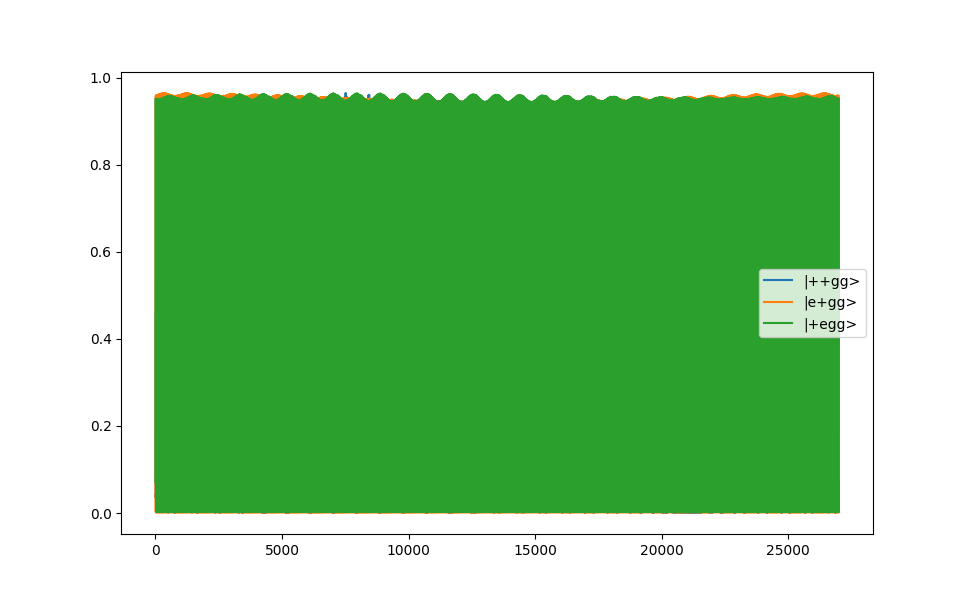

In [31]:
# plot the flatten fidelities
fig, ax = plt.subplots(1, 1)
ax.plot(fidelities_ppgg.flatten(), label='|++gg>')
ax.plot(fidelities_epgg.flatten(), label='|e+gg>')
ax.plot(fidelities_pegg.flatten(), label='|+egg>')


ax.legend()

In [32]:
psi_result_qubit_rot = {}

U_best = Z(phi1_vec[max_fid_idx_4q[0]], phi2_vec[max_fid_idx_4q[1]], phi3_vec[max_fid_idx_4q[2]], phi4_vec[max_fid_idx_4q[3]])

for psi in psi_result_qubit:

    psi_rot = U_best*psi_result_qubit[psi]
    psi_result_qubit_rot[psi] = psi_rot
    


4


 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_79425/3308495072.py: 20UserWarning: The figure layout has changed to tight
 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_79425/3308495072.py: 47

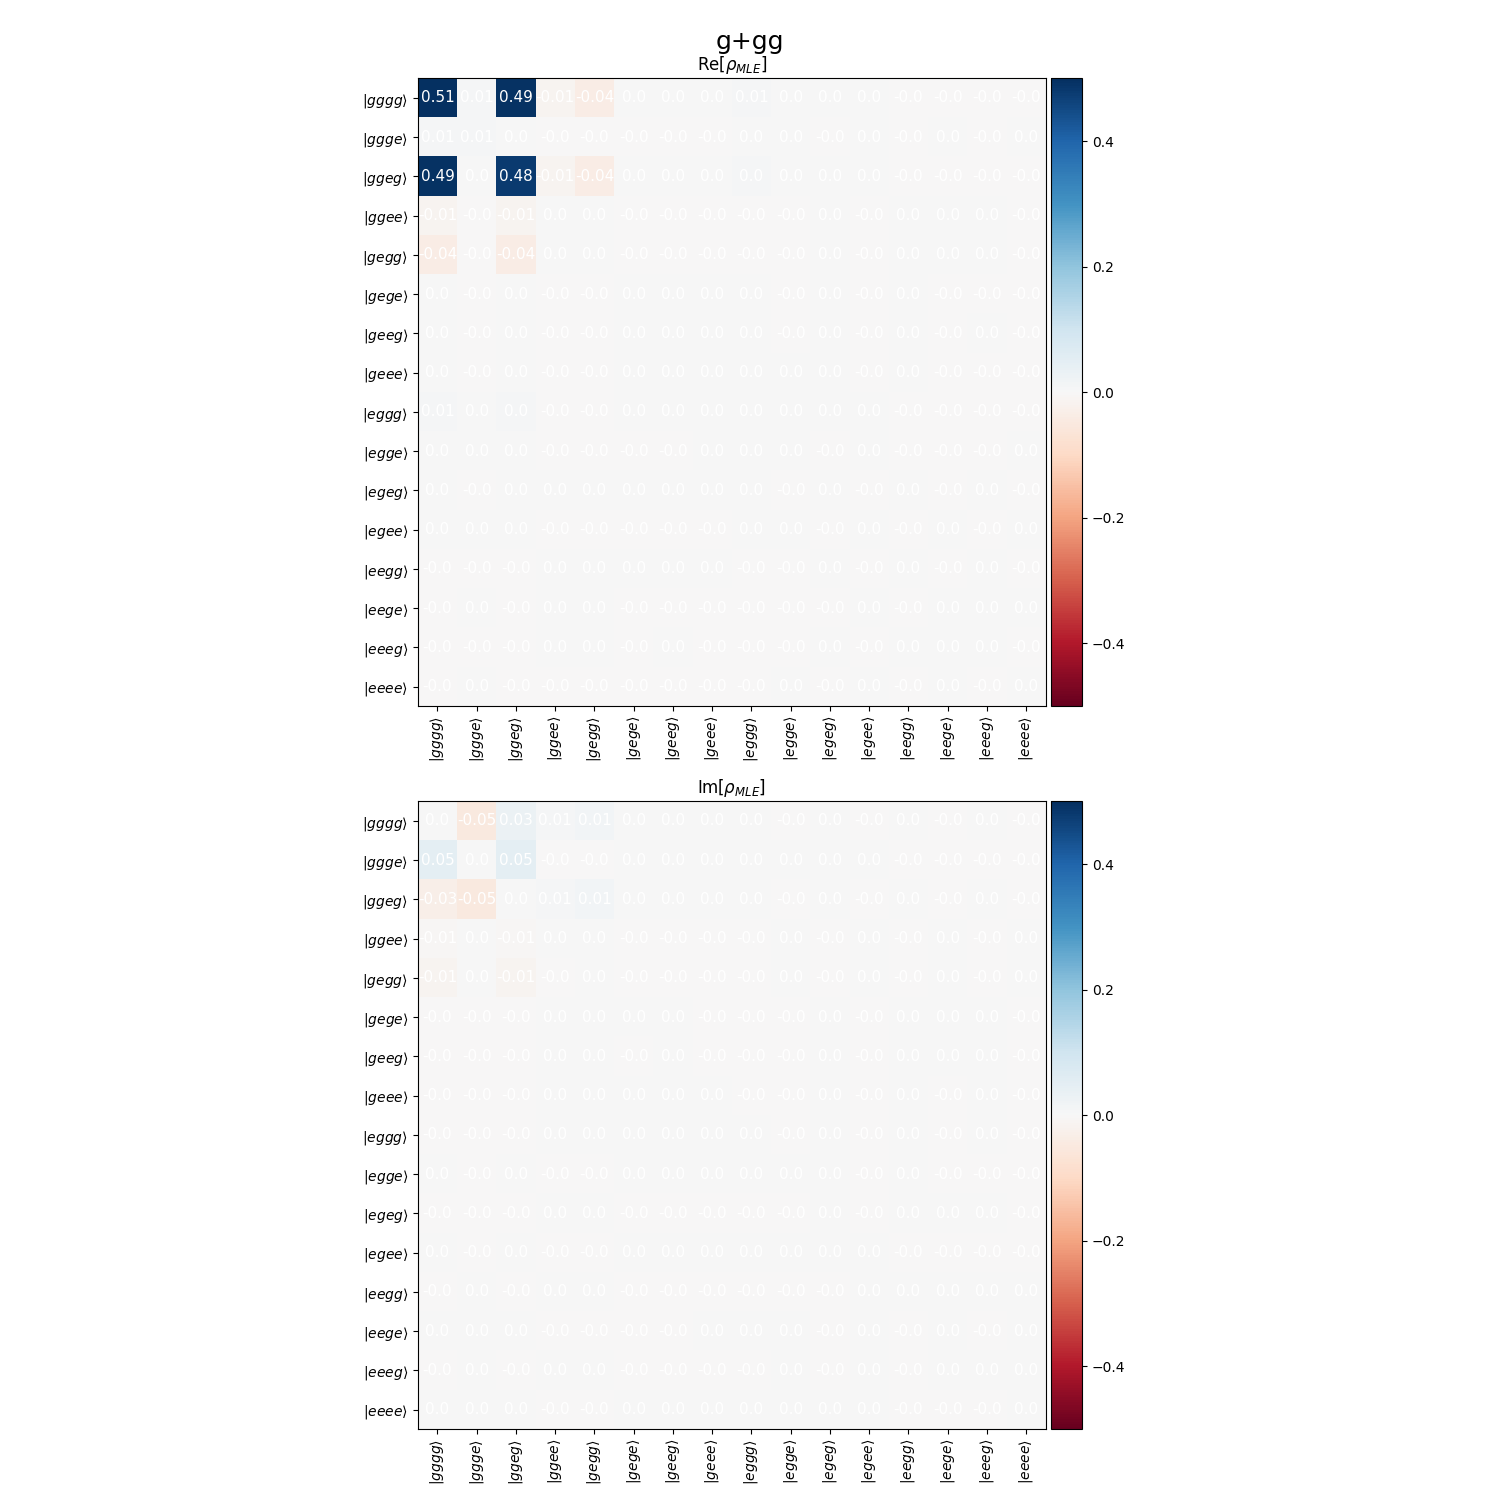

In [33]:
# plot the psi_result_qubit tomography
psi_idx = 'g+gg'
psi_show = psi_result_qubit_rot[psi_idx]
rho_plot = psi_show*psi_show.dag()

show_plot_rho_2d(rho_plot, title=psi_idx, cmax=0.5)

## For all state compute the fidelity with the target state

In [442]:
F = {}

for psi in psi_result_qubit_rot:
    F[psi] = qt.metrics.fidelity(psi_result_qubit_rot[psi], psi_f_qubit[psi])

In [443]:
# take the first element in F.keys()

psi_idx = list(F.keys())[0]

(0.9, 1.05)

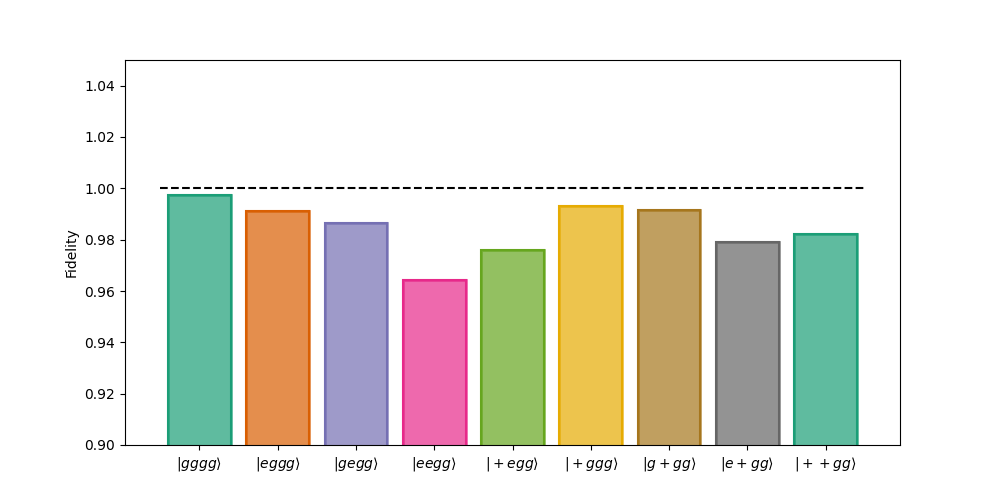

In [444]:
# plot an histogram of the fidelities

# the x label should be the states with a ket notation and vertical 

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x_list = list(F.keys())
x_labels = [f'$|{x}\\rangle$' for x in x_list]
# use color map Set1 

colors = plt.get_cmap('Dark2')(np.linspace(0, 1, len(x_list)-1))

# append a last color 

# colors = np.append(colors, plt.get_cmap('tab10')(9), axis=1)


ax.bar(x_labels, F.values(), color=colors, alpha=0.7, edgecolor=colors, linewidth=2)
ax.bar(x_labels, F.values(), color=colors, alpha=1, edgecolor=colors, linewidth=1.5, fill=False)

ax.set_ylabel('Fidelity')

# add a horizontal line at 1 

ax.hlines(1, -0.5, len(F)-0.5, linestyles='dashed', colors='black')
# ax.hlines(0.95, -0.5, len(F)-0.5, linestyles='dashed', colors='grey')


ax.set_ylim(0.9, 1.05)



### do the same but trace out Q1

In [445]:
psi_result_3Q = {}
psi_f_3Q = {}

for psi in psi_result:
    psi_temp =  psi_result_qubit[psi]
    psi_temp = psi_temp.ptrace([0, 2, 3])
    psi_result_3Q[psi] = psi_temp
    psi_temp =  psi_f_qubit[psi]
    psi_temp = psi_temp.ptrace([0, 2, 3])
    psi_f_3Q[psi] = psi_temp


In [449]:
# loop over the rotation angles and compute the fidelities

phi1_vec = np.linspace(0, 2*np.pi, 20)
phi2_vec = np.linspace(0, 2*np.pi, 20)
phi3_vec = np.linspace(0, 2*np.pi, 20)

fidelities_ppgg = np.zeros((len(phi1_vec), len(phi2_vec), len(phi3_vec)))
fidelities_epgg = np.zeros((len(phi1_vec), len(phi2_vec), len(phi3_vec)))
fidelities_pegg = np.zeros((len(phi1_vec), len(phi2_vec), len(phi3_vec)))
fidelities_gpgg = np.zeros((len(phi1_vec), len(phi2_vec), len(phi3_vec)))

for i, phi1 in enumerate(phi1_vec):
    for j, phi2 in enumerate(tqdm(phi2_vec)):
        for k, phi3 in enumerate(phi3_vec):
            U_rot = Z(phi1=phi1, phi2=phi2, phi3=phi3)
            psi_rot_1 = U_rot*psi_result_3Q['++gg']*U_rot.dag()
            psi_rot_2 = U_rot*psi_result_3Q['e+gg']*U_rot.dag()
            psi_rot_3 = U_rot*psi_result_3Q['+egg']*U_rot.dag()
            psi_rot_4 = U_rot*psi_result_3Q['g+gg']*U_rot.dag()
            fidelities_ppgg[i, j, k] = qt.fidelity(psi_rot_1, psi_f_3Q['++gg'])
            fidelities_epgg[i, j, k] = qt.fidelity(psi_rot_2, psi_f_3Q['e+gg'])
            fidelities_pegg[i, j, k] = qt.fidelity(psi_rot_3, psi_f_3Q['+egg'])
            fidelities_gpgg[i, j, k] = qt.fidelity(psi_rot_4, psi_f_3Q['g+gg'])


 50%|█████     | 10/20 [00:00<00:00, 12.43it/s]

100%|██████████| 20/20 [00:01<00:00, 12.47it/s]


In [450]:
# sum the fidelities and find the maximum and the corresponding indices

fidelities_sum = fidelities_ppgg + fidelities_epgg + fidelities_pegg
max_fid = np.max(fidelities_sum)/3

max_fid_idx_3q = np.unravel_index(np.argmax(fidelities_sum), fidelities_sum.shape)

print('max fidelity', max_fid)
print('max fidelity indices', max_fid_idx_3q)

max fidelity 0.9867140949364029
max fidelity indices (6, 7, 6)


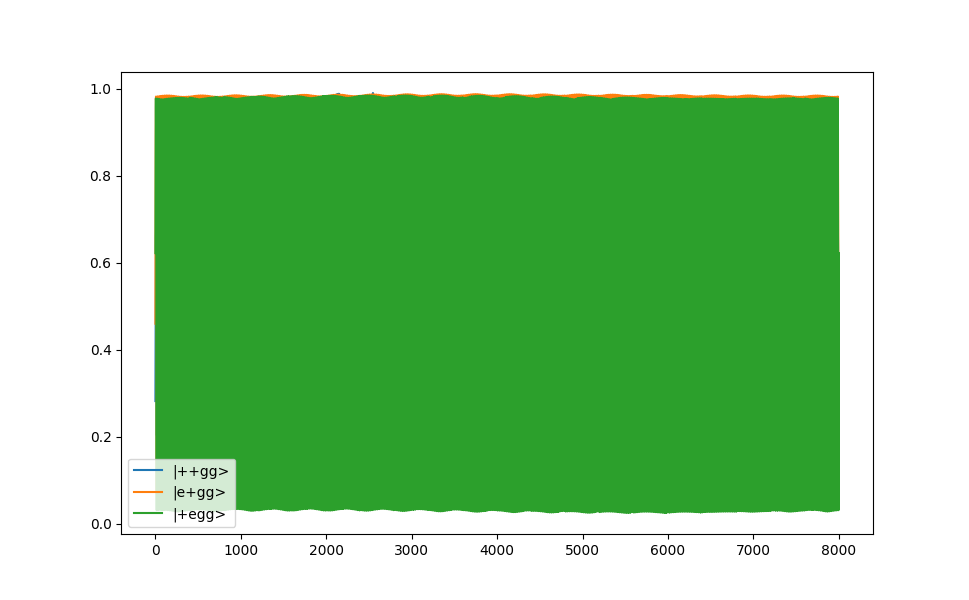

In [451]:
# plot the flatten fidelities

fig, ax = plt.subplots(1, 1)
ax.plot(fidelities_ppgg.flatten(), label='|++gg>')
ax.plot(fidelities_epgg.flatten(), label='|e+gg>')
ax.plot(fidelities_pegg.flatten(), label='|+egg>')

ax.legend()

In [452]:
psi_result_3Q_rot = {}

U_best = Z(phi1_vec[max_fid_idx_3q[0]], phi2_vec[max_fid_idx_3q[1]], phi3_vec[max_fid_idx_3q[2]])

for psi in psi_result_3Q:
    psi_rot = U_best*psi_result_3Q[psi]*U_best.dag()
    psi_result_3Q_rot[psi] = psi_rot

3


 C:\Users\slab\AppData\Local\Temp\ipykernel_20092\3308495072.py: 20UserWarning: The figure layout has changed to tight
 C:\Users\slab\AppData\Local\Temp\ipykernel_20092\3308495072.py: 47

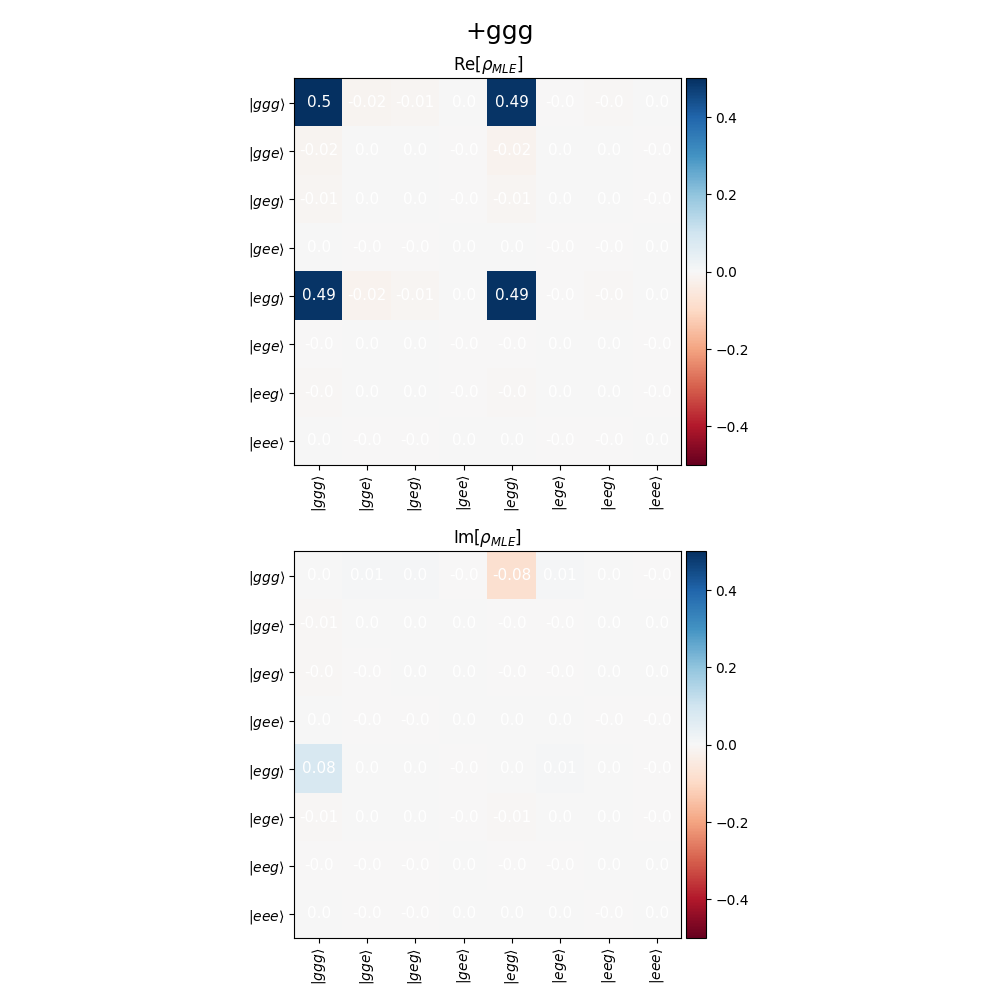

In [453]:
# plot the psi_result_qubit tomography
psi_idx = '+ggg'
rho_plot = psi_result_3Q_rot[psi_idx]


show_plot_rho_2d(rho_plot, title=psi_idx, cmax=0.5, figsize=(10, 10))

# For all state compute the fidelity with the target state

In [454]:
F_3Q = {}

for psi in psi_result_3Q_rot:
    F_3Q[psi] = qt.metrics.fidelity(psi_result_3Q_rot[psi], psi_f_3Q[psi])

In [455]:
psi_idx_3Q = list(F_3Q.keys())[0]

(0.9, 1.05)

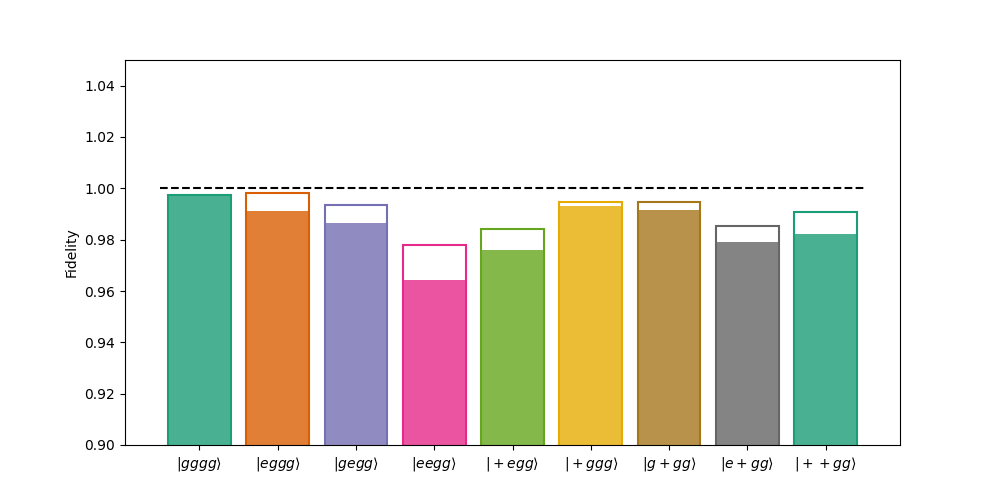

In [457]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

x_list = list(F_3Q.keys())
x_labels_3Q = [f'$|{x}\\rangle$' for x in x_list]
colors = plt.get_cmap('Dark2')(np.linspace(0, 1, len(x_list)-1))
x_labels

ax.bar(x_labels_3Q, F_3Q.values(), color=colors, alpha=1, edgecolor=colors, linewidth=1.5, fill=False)
ax.bar(x_labels, F.values(), color=colors, alpha=0.8)

ax.set_ylabel('Fidelity')

# add a horizontal line at 1

ax.hlines(1, -0.5, len(F_3Q)-0.5, linestyles='dashed', colors='black')
# ax.hlines(0.95, -0.5, len(F_3Q)-0.5, linestyles='dashed', colors='grey')

ax.set_ylim(0.9, 1.05)



# Check were the preparation error comes from

In [53]:

amp_pi = 0.03
seq_dict_prep = {}
phase=-np.pi/2
dead_time = 20 

for key in psi_init.keys():
    print(key)
    seq_temp = PulseSequence(start_time=0)
    q0_state = key[0]
    q1_state = key[1]

    if q0_state + q1_state != '++':
        if q0_state == 'e':
            qram.add_sequential_pi_pulse(seq_temp, 'gggg', 'eggg', drive_qubit=0, amp=amp_pi, phase=phase, type='gauss', sigma_n=5, verbose=False)
            if q1_state == 'e':
                qram.add_sequential_pi_pulse(seq_temp, 'eggg', 'eegg', drive_qubit=1, amp=amp_pi, phase=phase, type='gauss', sigma_n=5, verbose=False)
            if q1_state == '+':
                qram.add_sequential_pi_pulse(seq_temp, 'eggg', 'eegg', drive_qubit=1, amp=amp_pi, phase=phase, type='gauss', sigma_n=5, pihalf=True, verbose=False)

    if q0_state == 'g':
        if q1_state == 'e':
            qram.add_sequential_pi_pulse(seq_temp, 'gggg', 'gegg', drive_qubit=1, amp=amp_pi, phase=phase, type='gauss', sigma_n=5, verbose=False)
        if q1_state == '+':
            qram.add_sequential_pi_pulse(seq_temp, 'gggg', 'gegg', drive_qubit=1, amp=amp_pi, phase=phase, type='gauss', sigma_n=5, pihalf=True, verbose=False)

    if q0_state == '+':
        if q1_state == 'e':
            qram.add_sequential_pi_pulse(seq_temp, 'gggg', 'gegg', drive_qubit=1, amp=amp_pi, phase=phase, type='gauss', sigma_n=5, verbose=False)
            qram.add_sequential_pi_pulse(seq_temp, 'gegg', 'eegg', drive_qubit=0, amp=amp_pi, phase=phase, type='gauss', sigma_n=5, verbose=False, pihalf=True)
        if q1_state == 'g':
            qram.add_sequential_pi_pulse(seq_temp, 'gggg', 'eggg', drive_qubit=0, amp=amp_pi, phase=phase, type='gauss', sigma_n=5, verbose=False, pihalf=True)
        
    if q0_state+q1_state == '++':

        qram.add_sequential_pi_pulse(seq_temp, 'gggg', 'eggg', drive_qubit=0, amp=amp_pi, phase=phase, type='gauss', sigma_n=5, pihalf=True, verbose=False)

        w1 = qram.get_wd('gggg', 'gegg', amp=amp_pi/35, drive_qubit=1, verbose=False)
        w2 = qram.get_wd('eggg', 'eegg', amp=amp_pi/35, drive_qubit=1, verbose=False)
        qram.add_sequential_pi_pulse(seq_temp, 'gggg', 'gegg', drive_qubit=1, amp=amp_pi/35, phase=phase, type='gauss', sigma_n=5, wd=w1, pihalf=True, verbose=False)
        qram.add_sequential_pi_pulse(seq_temp, 'eggg', 'eegg', drive_qubit=1, amp=amp_pi/35, phase=phase, type='gauss', sigma_n=5, wd=w2, pihalf=True, verbose=False)


    seq_dict_prep[key] = seq_temp


gggg
eggg
1
One photon transition
One qubit gate
25.903845120340723
False
gegg
1
One photon transition
One qubit gate
21.655609756843557
False
eegg
1
One photon transition
One qubit gate
25.903845120340723
False
1
One photon transition
One qubit gate
21.592566158970133
False
+egg
1
One photon transition
One qubit gate
21.655609756843557
False
1
One photon transition
One qubit gate
25.872228656041127
True
+ggg
1
One photon transition
One qubit gate
25.903845120340723
True
g+gg
1
One photon transition
One qubit gate
21.655609756843557
True
e+gg
1
One photon transition
One qubit gate
25.903845120340723
False
1
One photon transition
One qubit gate
21.592566158970133
True
++gg
1
One photon transition
One qubit gate
25.903845120340723
True
1
One photon transition
One qubit gate
1
One photon transition
One qubit gate
21.625238732915818
True
21.592566158970133
True


In [111]:
psi_prep = {}

# take only few psi_init values

psi_temp = {}
temp = ['+egg', 'e+gg', '++gg', '+ggg']
for key in temp:
    psi_temp[key] = psi_init[key]


for psi in tqdm(psi_temp):
    print(psi)
    psi0 = gggg
    tf = seq_dict_prep[psi].time + dead_time
    times = np.linspace(0, tf, 300)
    result = qram.evolve(psi0, seq_dict_prep[psi], times, c_ops=None, nsteps=8000, progress=False)

    evals, evecs = qram.esys
    result_rot = 0*result[-1]
    e_disp, eig_disp
    # for E, eig in zip(evals, evecs):
    for E, eig in zip(e_disp, eig_disp):
        result_rot += np.exp(1j*E*tf) * eig.overlap(result[-1]) * eig


    psi_prep[psi] = result_rot

  0%|          | 0/4 [00:00<?, ?it/s]

+egg


 25%|██▌       | 1/4 [00:01<00:05,  1.77s/it]

e+gg


 50%|█████     | 2/4 [00:03<00:03,  1.75s/it]

++gg


 75%|███████▌  | 3/4 [00:37<00:16, 16.33s/it]

+ggg


100%|██████████| 4/4 [00:37<00:00,  9.48s/it]


In [112]:
psi_prep_qubit = {}

for psi in psi_temp:
    psi_prep_qubit[psi] = psi_prep[psi].full()[zeros]
    psi_prep_qubit[psi] = qt.Qobj(psi_prep_qubit[psi])
    psi_prep_qubit[psi].dims = [[2, 2, 2, 2], [1, 1, 1, 1]]

2


 C:\Users\slab\AppData\Local\Temp\ipykernel_12520\3308495072.py: 20UserWarning: The figure layout has changed to tight
 C:\Users\slab\AppData\Local\Temp\ipykernel_12520\3308495072.py: 47

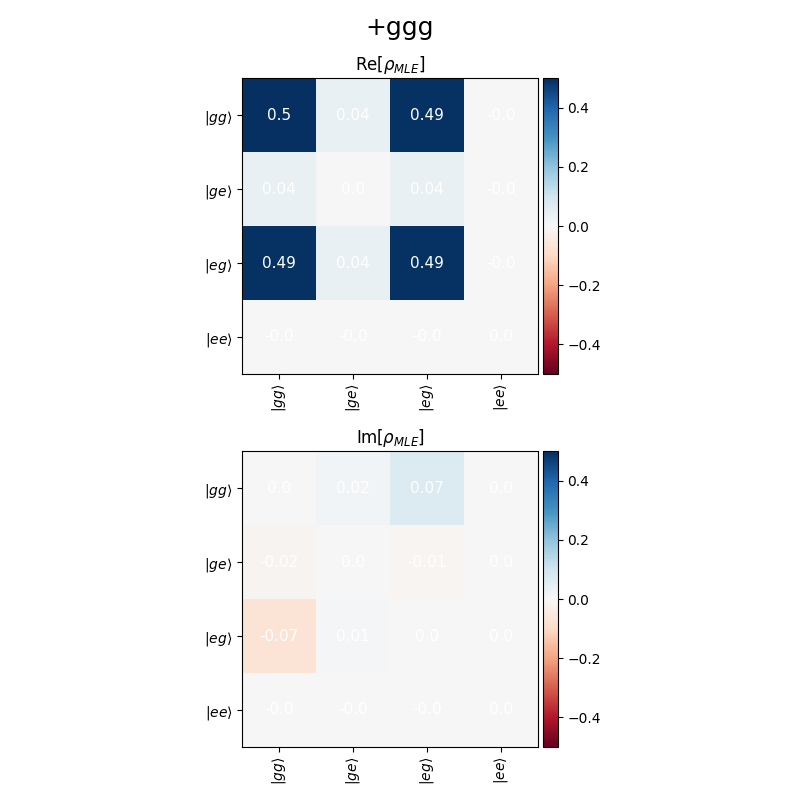

In [114]:
# plot the psi_result_qubit tomography
psi_idx = '+ggg'
psi_show = psi_prep_qubit[psi_idx]
rho_plot = psi_show*psi_show.dag()
rho_plot = qt.ptrace(rho_plot, [0,1])

show_plot_rho_2d(rho_plot, title=psi_idx, cmax=0.5, figsize=(8, 8))

# Control SWAP

In [130]:
qubit_freqs = None
alphas = None


EJs = None
ECs = None


rotating_frame = False


# qubit_eg = np.array([4116.60193514429-20,3450.456887958334, 4766.561902541384, 4381.086137747587 + 100])*1e-3
# qubit_ef = np.array([3890.5466932677664-20,3349.983151894969, 4576.680453599131,4210.642810651382 + 100])*1e-3

qubit_eg = np.array([4116.60193514429,3450.456887958334, 4766.561902541384])*1e-3
qubit_ef = np.array([3890.5466932677664,3349.983151894969, 4576.680453599131])*1e-3

alphas = (qubit_ef - qubit_eg)

gs = np.zeros((4, 4))
gs[0, 1] = 53.81744103399963e-3
gs[1, 2] = 55.95274071800953e-3
# gs[1, 3] = 44.5514225071792e-3
gs[0, 2] = 4.324246873301848e-3
# gs[0, 3] = 2.3034231276846207e-3
# gs[2, 3] = 6.286079155406997e-3

T1_eg = np.array([56.986352053917784, 85.60426751127089, 45.27317227359091, 51.26303063231619])*1e3
T1_ef = np.array([20, 20, 20, 20])*1e3

T2_eg = np.array([45.903071070836795, 56.380561904871904, 46.5, 24.674137658175617])*1e3
T2_ef = np.array([20, 20, 20, 20])*1e3

decay_rate_eg = 1/T1_eg
decay_rate_ef = 1/T1_ef

dephasing_rate_eg = 1/T2_eg - decay_rate_eg/2
dephasing_rate_ef = 1/T2_ef - decay_rate_ef/2



crosstalk = 0


In [131]:
# project in the TLS subspace 

# partial trace on the final states to keep only the qubit subspace

U1 = np.zeros((cutoffs[0], cutoffs[0]))
U2 = np.zeros((cutoffs[1], cutoffs[1]))
U3 = np.zeros((cutoffs[2], cutoffs[2]))
# U4 = np.zeros((cutoffs[3], cutoffs[3]))

U1[:2, :2] = qt.qeye(2).full()
U2[:2, :2] = qt.qeye(2).full()
U3[:2, :2] = qt.qeye(2).full()
# U4[:2, :2] = qt.qeye(2).full()

U1 = qt.Qobj(U1)
U2 = qt.Qobj(U2)
U3 = qt.Qobj(U3)
# U4 = qt.Qobj(U4)

# U = qt.tensor(U1, U2, U3, U4).full()
U = qt.tensor(U1, U2, U3).full()

zeros = np.argwhere(np.diag(U) != 0).flatten()



 C:\Users\slab\AppData\Local\Temp\ipykernel_19564\3313300357.py: 10ComplexWarning: Casting complex values to real discards the imaginary part
 C:\Users\slab\AppData\Local\Temp\ipykernel_19564\3313300357.py: 11ComplexWarning: Casting complex values to real discards the imaginary part
 C:\Users\slab\AppData\Local\Temp\ipykernel_19564\3313300357.py: 12

In [132]:
# cutoffs = [4, 4, 4, 3]
cutoffs = [4, 4, 4]
# isCavity = [False, False, False, False]
isCavity = [False, False, False]



qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    qubit_freqs=qubit_eg,
    alphas=alphas,
    cutoffs=cutoffs,
    isCavity=isCavity,
    crosstalk=crosstalk
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
# print('qubit freqs (GHz)', *qubit_freqs)
# print('alphas (GHz)', *alphas)
# print('aprox sideband freqs (GHz)', (2*qubit_freqs[2] + alphas[2] - qubit_freqs[1], 2*qubit_freqs[3] + alphas[3] - qubit_freqs[1]))
# print([qram.get_base_wd('ggeg', 'gfgg')/2/np.pi])


# print('capacitances (fF)', *(qe**2/(2*h*np.array(ECs)*1e9)*1e15))
# print('lumped L (nH)', *(red_flux_quant**2/h/np.array(EJs)))

[4.11660194 3.45045689 4.7665619 ]
[-0.22605524 -0.10047374 -0.18988145]


In [133]:
# # eggg = qram.state('eggg')
# # gegg = qram.state('gegg')
# # ggeg = qram.state('ggeg')
# # ggge = qram.state('ggge')

# egg = qram.state('egg')
# geg = qram.state('geg')
# gge = qram.state('gge')


# # w_q0 = eggg.dag()*qram.H*eggg/2/np.pi
# # w_q1 = gegg.dag()*qram.H*gegg/2/np.pi
# # w_q2 = ggeg.dag()*qram.H*ggeg/2/np.pi
# # w_q3 = ggge.dag()*qram.H*ggge/2/np.pi


# w_q0 = egg.dag()*qram.H*egg/2/np.pi
# w_q1 = geg.dag()*qram.H*geg/2/np.pi
# w_q2 = gge.dag()*qram.H*gge/2/np.pi


# # H_rot = 2*np.pi*w_q0*qram.a_ops[0].dag()*qram.a_ops[0]
# # H_rot += 2*np.pi*w_q1*qram.a_ops[1].dag()*qram.a_ops[1]
# # H_rot += 2*np.pi*w_q2*qram.a_ops[2].dag()*qram.a_ops[2]
# # H_rot += 2*np.pi*w_q3*qram.a_ops[3].dag()*qram.a_ops[3]

# H_rot = 2*np.pi*w_q0*qram.a_ops[0].dag()*qram.a_ops[0]
# H_rot += 2*np.pi*w_q1*qram.a_ops[1].dag()*qram.a_ops[1]
# H_rot += 2*np.pi*w_q2*qram.a_ops[2].dag()*qram.a_ops[2]

# e_disp, eig_disp = H_rot.eigenstates()


H_rot = qram.H*0

for i in range(cutoffs[0]):
    for j in range(cutoffs[1]):
        for k in range(cutoffs[2]):
            # for l in range(cutoffs[3]):
            # psi_ids = [i, j, k, l]
            psi_ids = [i, j, k]
            psi = qram.level_nums_to_name(psi_ids)
            psi_i = qram.level_nums_to_name([i,0,0])
            psi_j = qram.level_nums_to_name([0,j,0])
            psi_k = qram.level_nums_to_name([0,0,k])
            ket = qram.state(psi)
            ket_i = qram.state(psi_i)
            ket_j = qram.state(psi_j)
            ket_k = qram.state(psi_k)
            wi = ket_i.dag()*qram.H*ket_i/2/np.pi
            wj = ket_j.dag()*qram.H*ket_j/2/np.pi
            wk = ket_k.dag()*qram.H*ket_k/2/np.pi
            H_rot += (wi + wj + wk)*ket*ket.dag()


e_disp, eig_disp = H_rot.eigenstates()


In [134]:
seq_cswap = PulseSequence(start_time=0)


# wd_ef = qram.add_sequential_pi_pulse(seq_cswap, 'ggfg', 'ggeg', drive_qubit=2, amp=amp, phase=0, type='gauss', sigma_n=6)
# qram.add_sequential_pi_pulse(seq_cswap, 'ggfg', 'gegg', amp_12_opt, drive_qubit=2, phase=phase_12, type='const', wd=wd_12, t_rise=1, t_pulse=t12, t_offset=dead_time_prep)
# qram.add_sequential_pi_pulse(seq_cswap, 'ggfg', 'ggeg', drive_qubit=2, amp=amp, phase=0, type='gauss', wd=pi2, t_pulse=tef2, sigma_n=6)


wd_ef_g = qram.get_wd('ggf', 'gge', amp=amp, drive_qubit=2)
wd_ef_e = qram.get_wd('gef', 'gee', amp=amp, drive_qubit=2)
wd_ef = np.average([wd_ef_g, wd_ef_e])



qram.add_sequential_pi_pulse(seq_cswap, 'ggf', 'gge', drive_qubit=2, amp=amp, phase=0, type='gauss', sigma_n=6, wd=wd_ef)
wd_swap = qram.add_sequential_pi_pulse(seq_cswap, 'ggf', 'geg', amp=0.14*2.1, drive_qubit=2, phase=phase_12, type='const', t_rise=1, t_offset=dead_time_prep)
qram.add_sequential_pi_pulse(seq_cswap, 'ggf', 'gge', drive_qubit=2, amp=amp, phase=0, type='gauss', wd=wd_ef, sigma_n=6)








# qram.add_sequential_pi_pulse(seq, 'eggf', 'eegg', amp_13_opt, drive_qubit=3, phase=phase_13, type='const', wd=wd_13, t_rise=1, t_pulse=t13, t_offset=-t12)
# qram.add_sequential_pi_pulse(seq_cswap, 'eggf', 'egge', drive_qubit=3, amp=amp_ef, phase=0, type='gauss', t_offset=1, wd=pi3, sigma_n=4, t_pulse=tef3)




# add the rotation gate on q0
# qram.add_sequential_pi_pulse(seq, 'eggg', 'gggg', drive_qubit=0, amp=amp, phase=-np.pi/2, type='gauss', wd=pi0, t_pulse=t0, sigma_n=5, t_offset=2)
# qram.add_sequential_pi_pulse(seq, 'eggg', 'gggg', drive_qubit=0, amp=amp, phase=-np.pi/2 - phi_rot[0], type='gauss', wd=pi0, t_pulse=t0, sigma_n=5, t_offset=2)

1
One photon transition
One qubit gate
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.012337555648093468
        x: [ 2.879e+01]
      nit: 2
      jac: [ 2.851e-05]
     nfev: 8
     njev: 4
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
final drive freq (GHz) 28.79260455756132
1
One photon transition
One qubit gate
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.03755500513707011
        x: [ 2.877e+01]
      nit: 8
      jac: [-2.449e-03]
     nfev: 56
     njev: 28
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
final drive freq (GHz) 28.770523685189996
28.78156412137566
False
1
One photon transition
Two qubit gate
hello
  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.006814302264426031
        x: [ 3.704e+01]
      nit: 4
      jac: [-9.992e-08]
     nfev: 22
     njev: 11
 hess_inv: <1x1 LbfgsInvHessProdu

28.78156412137566

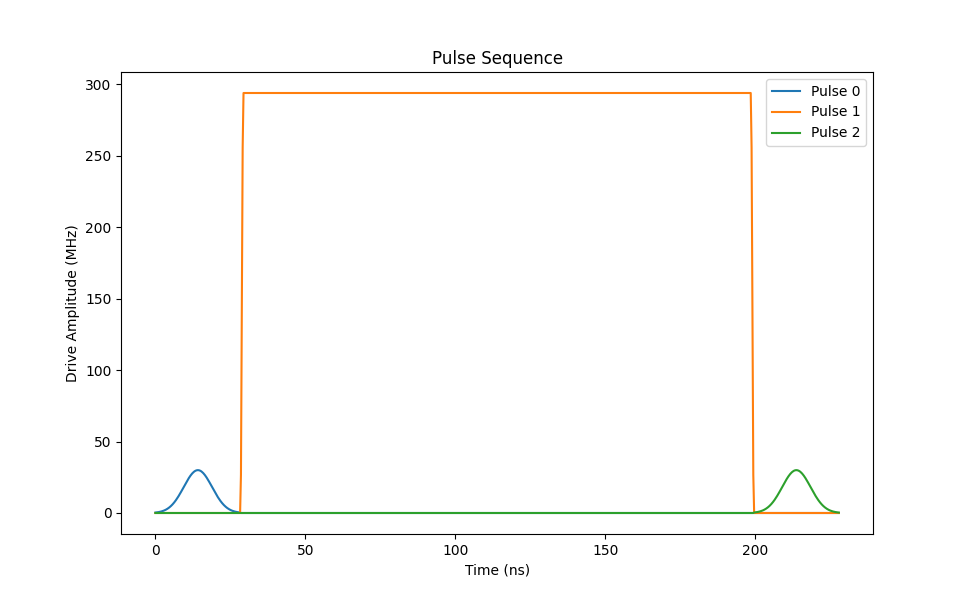

In [135]:
envelope_seq = seq_cswap.get_envelope_seq()
pulse_amps = seq_cswap.get_pulse_amps()
pulse_lens = seq_cswap.get_pulse_lengths()
tf = seq_cswap.time
times = np.linspace(0, tf, 800)
flat_times = np.array(times).flatten()

figp, axp = plt.subplots(1, 1)

for i in range(len(envelope_seq)):
    axp.plot(flat_times, [pulse_amps[i]*envelope_seq[i](t)/MHz for t in flat_times], label=f'Pulse {i}')
axp.set_xlabel('Time (ns)')
axp.set_ylabel('Drive Amplitude (MHz)')
axp.set_title('Pulse Sequence')
axp.legend()

In [136]:
psi_base_cswap = {}
psi_input_cswap = {}




for i in range(2):
    for j in range(2):
        for k in range(2):
            psi_ids = [i, j, k]
            psi = qram.level_nums_to_name(psi_ids)
            psi_base_cswap[psi] = qram.state(psi)



psi_input_cswap['+++'] = (qram.state('ggg') + qram.state('geg') + qram.state('gge') + qram.state('gee') + qram.state('egg') + qram.state('eeg') + qram.state('ege') + qram.state('eee')).unit()
psi_input_cswap['+gg'] = (qram.state('egg') + qram.state('ggg')).unit()
psi_input_cswap['g+g'] = (qram.state('geg') + qram.state('ggg')).unit()
psi_input_cswap['gg+'] = (qram.state('gge') + qram.state('ggg')).unit()
psi_input_cswap['g+g'] = (qram.state('geg') + qram.state('ggg')).unit()
psi_input_cswap['g++'] = (qram.state('gge') + qram.state('geg') + qram.state('ggg') + qram.state('gee')).unit()
psi_input_cswap['gge'] = qram.state('gge')
psi_input_cswap['geg'] = qram.state('geg')
psi_input_cswap['ggg'] = qram.state('ggg')
psi_input_cswap['gee'] = qram.state('gee')
psi_input_cswap['eee'] = qram.state('eee')
psi_input_cswap['eeg'] = qram.state('eeg')
psi_input_cswap['ege'] = qram.state('ege')
psi_input_cswap['e++'] = (qram.state('egg') + qram.state('eeg') + qram.state('ege') + qram.state('eee')).unit()
psi_input_cswap['eg+'] = (qram.state('ege') + qram.state('egg')).unit()
psi_input_cswap['e+g'] = (qram.state('eeg') + qram.state('egg')).unit()




In [137]:
# partial trace on the final states to keep only the qubit subspace

U1 = np.zeros((cutoffs[0], cutoffs[0]))
U2 = np.zeros((cutoffs[1], cutoffs[1]))
U3 = np.zeros((cutoffs[2], cutoffs[2]))

U1[:2, :2] = qt.qeye(2).full()
U2[:2, :2] = qt.qeye(2).full()
U3[:2, :2] = qt.qeye(2).full()

U1 = qt.Qobj(U1)
U2 = qt.Qobj(U2)
U3 = qt.Qobj(U3)

P = qt.tensor(U1, U2, U3).full()

zeros_P = np.argwhere(np.diag(P) != 0).flatten()

 C:\Users\slab\AppData\Local\Temp\ipykernel_19564\4029819045.py: 7ComplexWarning: Casting complex values to real discards the imaginary part
 C:\Users\slab\AppData\Local\Temp\ipykernel_19564\4029819045.py: 8ComplexWarning: Casting complex values to real discards the imaginary part
 C:\Users\slab\AppData\Local\Temp\ipykernel_19564\4029819045.py: 9

In [138]:

rotating_frame = False 
psi0 = psi_input_cswap['e++']
# psi0 = psi_base_cswap['+++']
result = qram.evolve(psi0, seq_cswap, times, c_ops=None, nsteps=8000, progress=False)

result_rot = [0*result[i_t] for i_t in range(len(times))]

for i_t, t in enumerate(tqdm(times)):
    # for eval, evec in zip(evals, evecs):
    for E, eig in zip(e_disp, eig_disp):
        # print(E, eig)
        result_rot[i_t] += np.exp(1j*E*t) * eig.overlap(result[i_t]) * eig
    # break


# pick up the relevant states for the protocol 

psi_plot = []

for t in [0, 2*len(times)//3,-1]:
    for i in range(cutoffs[0]):
        for j in range(cutoffs[1]):
            for k in range(cutoffs[2]):
                # for l in range(cutoffs[3]):
                # psi_ids = [i, j, k, l]
                psi_ids = [i, j, k]
                psi = qram.level_nums_to_name(psi_ids)
                # print(psi)
                ov = np.abs(result_rot[t].overlap(qram.state(psi)))
                if ov > 0.05:
                    print(psi, ov)
                    psi_plot.append(psi)

psi_plot = list(set(psi_plot))

100%|██████████| 800/800 [00:08<00:00, 91.16it/s]


egg 0.5000000000000002
ege 0.5000000000000002
eeg 0.5
eee 0.5
egg 0.496345766757979
ege 0.07280941177892217
egf 0.5576108579446849
egh 0.10762967241153001
eeg 0.41228957706533925
eee 0.1559010989331851
eef 0.4712559796981561
eeh 0.09641362220085323
egg 0.4999768205392896
ege 0.551006312310229
eeg 0.44437860997067696
eee 0.49709928900771677


In [139]:
psi_evol_qubit = result_rot[-1].full()[zeros]
psi_evol_qubit = qt.Qobj(psi_evol_qubit)
psi_evol_qubit.dims = [[2, 2, 2], [1, 1, 1]]

Quantum object: dims = [[4, 4, 4], [1, 1, 1]], shape = (64, 1), type = ket
Qobj data =
[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 9.92759620e-02]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.51033218e-02]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 9.70284258e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.31260176e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 7.72944706e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.75939808e-01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.43536521e-02]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 2.18128220e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 8.02204708e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 

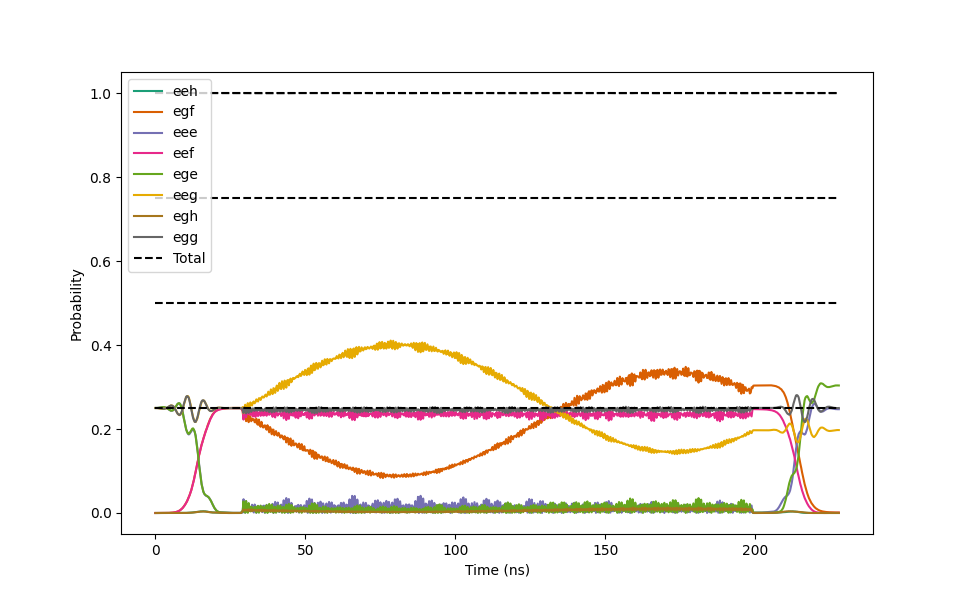

In [140]:
cmap = plt.get_cmap('Dark2')
colors = cmap(np.linspace(0, 1, len(psi_plot)))
figs, axs = plt.subplots(1, 1)

prob_sum = np.zeros(len(times))

for psi in psi_plot:
    state = qram.state(psi)
    prob = [np.abs(state.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_sum += prob

for psi in psi_plot: 
    state = qram.state(psi)
    print(state)
    print(result_rot[0])

    # prob = [np.abs(state.dag()*result_rot[t]*state.full()).flatten() for t in range(len(times))]
    prob = [np.abs(state.overlap(result_rot[t]))**2 for t in range(len(times))]

    axs.plot(times, prob, label=psi, color=colors[psi_plot.index(psi)])

axs.plot(times, prob_sum, label='Total', color='black', linestyle='dashed')

axs.hlines(0.5, 0, times[-1], linestyles='dashed', colors='black')
axs.hlines(1, 0, times[-1], linestyles='dashed', colors='black')
axs.hlines(0.25, 0, times[-1], linestyles='dashed', colors='black')
axs.hlines(0.75, 0, times[-1], linestyles='dashed', colors='black')
axs.set_xlabel('Time (ns)')
axs.set_ylabel('Probability')

axs.legend(loc='upper left')

In [115]:
# compute the evolution for all input state 

psi_result_cswap = {}

for psi in tqdm(psi_base_cswap):
    print(psi)
    psi0 = psi_base_cswap[psi]
    result = qram.evolve(psi0, seq_cswap, times, c_ops=None, nsteps=8000, progress=False)
    result_rot = 0*result[-1]
    for E, eig in zip(e_disp, eig_disp):
        result_rot += np.exp(1j*E*tf) * eig.overlap(result[-1]) * eig


    psi_result_cswap[psi] = result_rot

  0%|          | 0/8 [00:00<?, ?it/s]

ggg


 12%|█▎        | 1/8 [00:04<00:29,  4.17s/it]

gge


 25%|██▌       | 2/8 [00:07<00:21,  3.55s/it]

geg


 38%|███▊      | 3/8 [00:10<00:17,  3.45s/it]

gee


 50%|█████     | 4/8 [00:14<00:13,  3.50s/it]

egg


 62%|██████▎   | 5/8 [00:17<00:10,  3.39s/it]

ege


 75%|███████▌  | 6/8 [00:20<00:06,  3.45s/it]

eeg


 88%|████████▊ | 7/8 [00:24<00:03,  3.47s/it]

eee


100%|██████████| 8/8 [00:28<00:00,  3.57s/it]


In [116]:
psi_output_cswap = {}

for psi in psi_input_cswap:

    psi0 = psi_input_cswap[psi]
    result = qram.evolve(psi0, seq_cswap, times, c_ops=None, nsteps=8000, progress=False)
    result_rot = 0*result[-1]
    for E, eig in zip(e_disp, eig_disp):
        result_rot += np.exp(1j*E*tf) * eig.overlap(result[-1]) * eig

    psi_output_cswap[psi] = result_rot
    


In [117]:
psi_base_qubit = {}
psi_result_qubit = {}
psi_output_qubit = {}
psi_input_qubit= {}

for psi in psi_base_cswap.keys():
    # psi_rot = U_best*psi_result[psi]
    psi_base_qubit[psi] = psi_base_cswap[psi].full()[zeros_P]
    psi_base_qubit[psi] = qt.Qobj(psi_base_qubit[psi])
    psi_base_qubit[psi].dims = [[2, 2, 2], [1, 1, 1]]
    psi_result_qubit[psi] = psi_result_cswap[psi].full()[zeros_P]
    psi_result_qubit[psi] = qt.Qobj(psi_result_qubit[psi])
    psi_result_qubit[psi].dims = [[2, 2, 2], [1, 1, 1]]
for psi in psi_output_cswap.keys():
    psi_output_qubit[psi] = psi_output_cswap[psi].full()[zeros_P]
    psi_output_qubit[psi] = qt.Qobj(psi_output_qubit[psi])
    psi_output_qubit[psi].dims = [[2, 2, 2], [1, 1, 1]]
    psi_input_qubit[psi] = psi_input_cswap[psi].full()[zeros_P]
    psi_input_qubit[psi] = qt.Qobj(psi_input_qubit[psi])
    psi_input_qubit[psi].dims = [[2, 2, 2], [1, 1, 1]]




In [118]:
U = np.zeros((2**3, 2**3), dtype=complex)

for i in range(len(psi_base_qubit)):
        for j in range(len(psi_base_qubit)):
                ket_i = psi_base_qubit[list(psi_base_qubit.keys())[i]]
                ket_j = psi_result_qubit[list(psi_result_qubit.keys())[j]]
                # idx_1 = np.argmax(np.abs(ket_i.full()))
                # idx_2 = np.argmax(np.abs(ket_j.full()))
                U[i, j] = (ket_i.dag()*ket_j)[0][0][0]



U = qt.Qobj(U)
U.dims = [[2, 2, 2], [2, 2, 2]]


In [119]:
print(psi_base_qubit['eee'])

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.97590406]]


In [120]:
# define the ideal c-SWAP matrix:
d = np.ones(2**3, dtype=complex)
U_ideal = np.diag(d)

U_ideal[3, 3] = -1
U_ideal[7, 7] = -1
U_ideal[1, 1] = 0
U_ideal[2, 2] = 0
U_ideal[1, 2] = -1
U_ideal[2, 1] = -1
U_ideal[5, 5] = -1




U_ideal = qt.Qobj(U_ideal)
U_ideal.dims = [[2, 2, 2], [2, 2, 2]]

In [121]:
# find the rotation angle 

phi_1_vec = np.linspace(0, 2*np.pi, 20)
phi_2_vec = np.linspace(0, 2*np.pi, 20)
phi_3_vec = np.linspace(0, 2*np.pi, 20)

fidelities = np.zeros((len(phi_1_vec), len(phi_2_vec), len(phi_3_vec)))

for i, phi_1 in enumerate(phi_1_vec):
    for j, phi_2 in enumerate(tqdm(phi_2_vec)):
        for k, phi_3 in enumerate(phi_3_vec):
            U_rot = Z(phi1=phi_1, phi2=phi_2, phi3=phi_3)
            # print(np.abs(np.linalg.det(U_ideal.full())))
            # print(np.abs(np.linalg.det(U_rot.full())))
            # print(np.abs(np.linalg.det(U.full())))
            U_test = U_rot*U
            # print(np.abs(np.linalg.det(U_test.full())))
            f = qt.fidelity(U_test, U_ideal)
            fidelities[i, j, k] = f/8

100%|██████████| 20/20 [00:00<00:00, 31.15it/s]


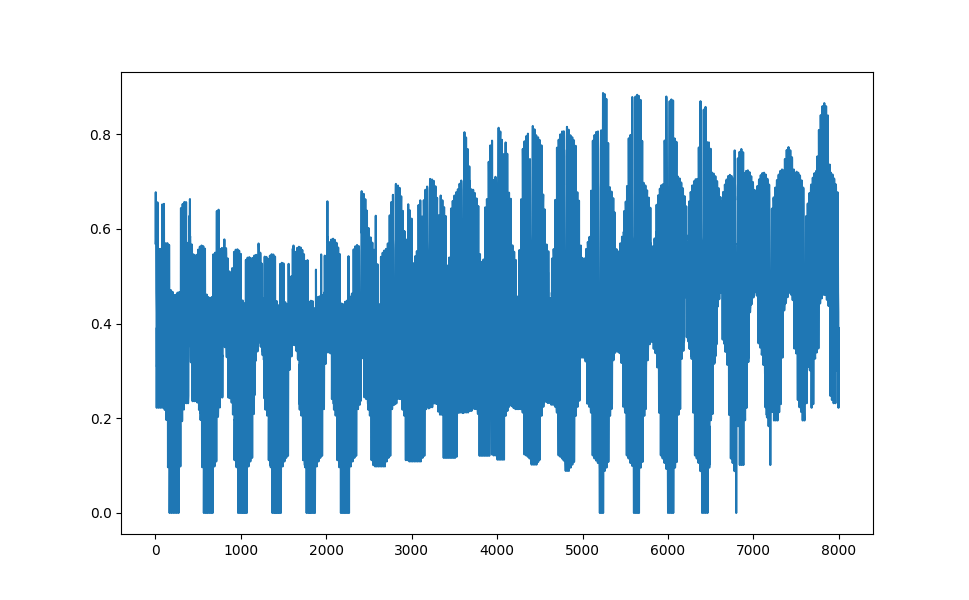

In [122]:
fig, ax = plt.subplots(1, 1)

ax.plot(fidelities.flatten())

In [123]:
# best angles 

max_fid = np.max(fidelities)
max_fid_idx = np.unravel_index(np.argmax(fidelities), fidelities.shape)

print('max fidelity', max_fid)
print('max fidelity indices', max_fid_idx)
Z_best = Z(phi1=phi_1_vec[max_fid_idx[0]], phi2=phi_2_vec[max_fid_idx[1]], phi3=phi_3_vec[max_fid_idx[2]])
U_best = Z_best*U


max fidelity 0.8869288920654526
max fidelity indices (13, 1, 19)


3


 C:\Users\slab\AppData\Local\Temp\ipykernel_19564\3308495072.py: 20UserWarning: The figure layout has changed to tight
 C:\Users\slab\AppData\Local\Temp\ipykernel_19564\3308495072.py: 47

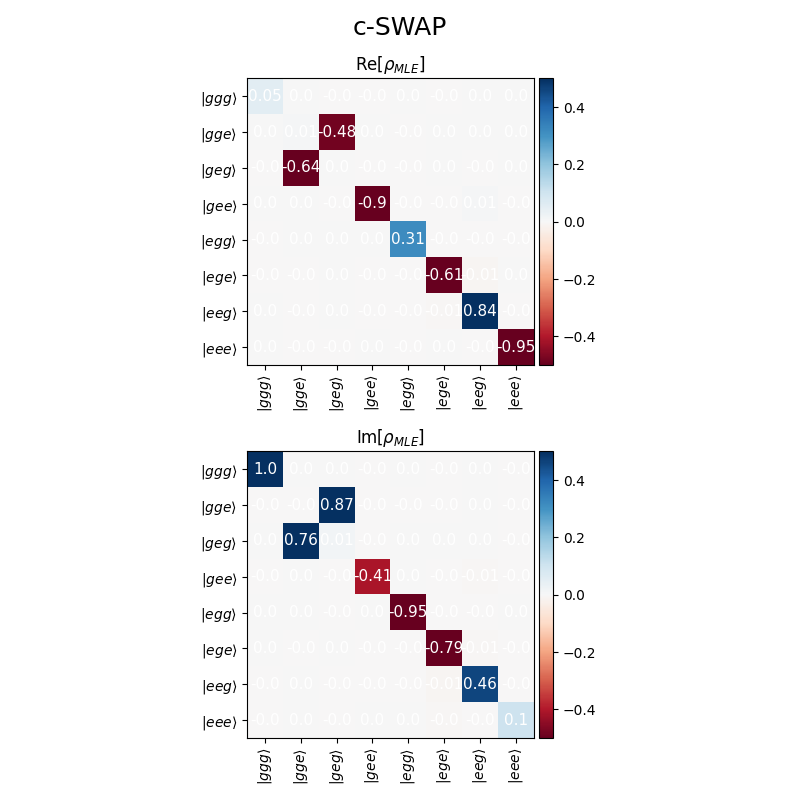

3


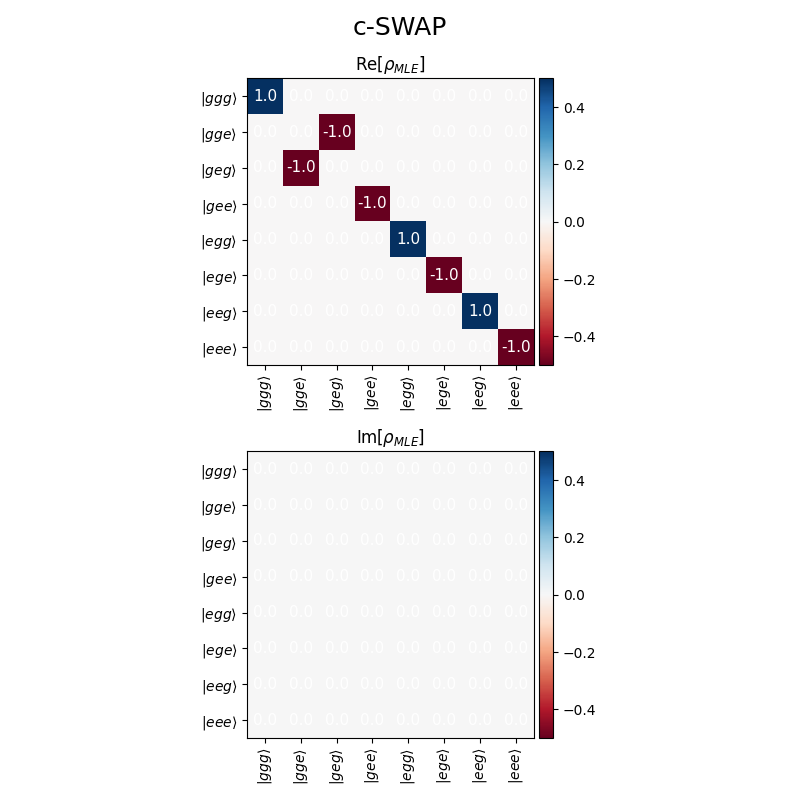

In [124]:
# Up = qt.ptrace(U, [0, 1, 2])
# show_plot_rho_2d(U_best, title='c-SWAP', cmax=0.5, figsize=(8, 8))
show_plot_rho_2d(U_best, title='c-SWAP', cmax=0.5, figsize=(8, 8))
show_plot_rho_2d(U_ideal, title='c-SWAP', cmax=0.5, figsize=(8, 8))


0.27448927475459056
3


 C:\Users\slab\AppData\Local\Temp\ipykernel_19564\3308495072.py: 20UserWarning: The figure layout has changed to tight
 C:\Users\slab\AppData\Local\Temp\ipykernel_19564\3308495072.py: 47

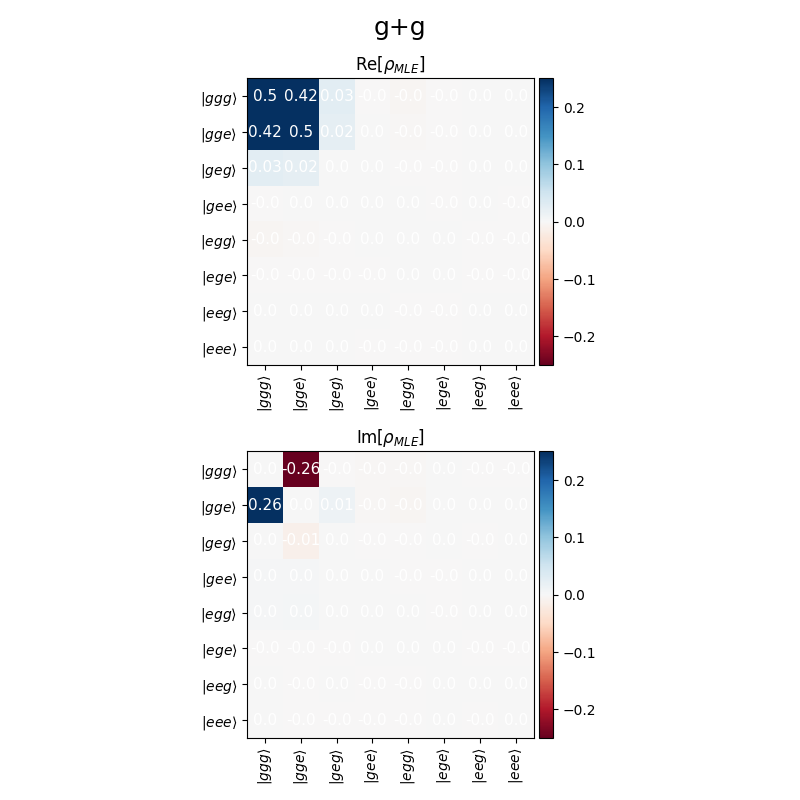

3


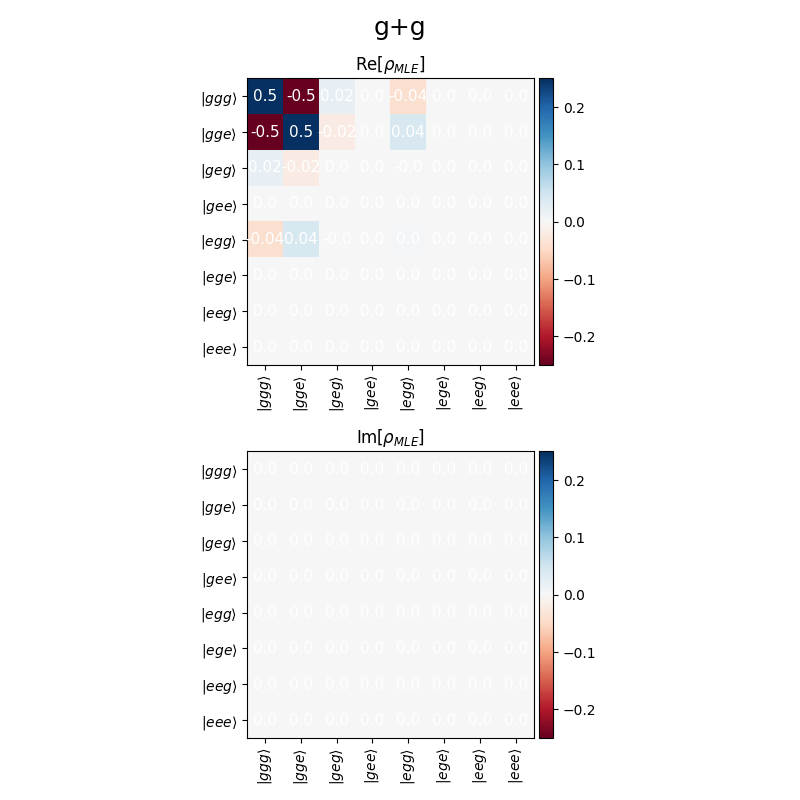

In [129]:
psi_plot_idx = 'g+g'
# psi_plot = U_best*psi_base_qubit[psi_plot_idx]
# psi_plot = psi_result_qubit[psi_plot_idx]
# psi_plot = result_rot[-1]

# psi_plot = psi_output_qubit[psi_plot_idx]
# psi_plot = psi_evol_qubit

psi_plot_ideal = U_ideal*psi_input_qubit[psi_plot_idx]
# psi_plot_ideal = U_best*psi_input_qubit['+++']
Z_unrotate = Z(phi1=-phi_1_vec[max_fid_idx[0]], phi2=-phi_2_vec[max_fid_idx[1]], phi3=-phi_3_vec[max_fid_idx[2]])
psi_plot = Z_unrotate*psi_output_qubit[psi_plot_idx]

print(qt.fidelity(psi_plot_ideal, psi_plot))


show_plot_rho_2d(psi_plot*psi_plot.dag(), title=psi_plot_idx, cmax=0.25, figsize=(8, 8))
show_plot_rho_2d(psi_plot_ideal*psi_plot_ideal.dag(), title=psi_plot_idx, cmax=0.25, figsize=(8, 8))

# Accounting for the decay channels 

In [297]:
# T1_eg 
c_ops_list = []




for k in range(len(cutoffs)):

    # ket = qram.state('gggg')
    # str_bra = 'g'*k + 'e' + 'g'*(3-k)
    # bra = qram.state(str_bra)
    ket = qt.basis(cutoffs[k], 0)
    bra = qt.basis(cutoffs[k], 1).dag()
    tensor = [ket*bra if i == k else qt.qeye(cutoffs[i]) for i in range(len(cutoffs))]
    c_ops = [np.sqrt(decay_rate_eg[k])*qt.tensor(tensor)]
    c_ops_list.append(c_ops[0])



# T1_fe
    
for k in range(len(cutoffs)):

    ket =qt.basis(cutoffs[k], 1)
    bra = qt.basis(cutoffs[k], 2).dag()
    tensor = [ket*bra if i == k else qt.qeye(cutoffs[i]) for i in range(len(cutoffs))]
    c_ops = [np.sqrt(decay_rate_ef[k])*qt.tensor(tensor)]
    c_ops_list.append(c_ops[0])

# dephasing eg, their is a factor 2 in the dephasing rate for consistency
    
for k in range(len(cutoffs)):

    ket = qt.basis(cutoffs[k], 1)
    tensor = [ket*ket.dag() if i == k else qt.qeye(cutoffs[i]) for i in range(len(cutoffs))]
    c_ops = [np.sqrt(2*dephasing_rate_eg[k])*qt.tensor(tensor)]
    c_ops_list.append(c_ops[0])

# dephasing fe
    
for k in range(len(cutoffs)):
    
    ket = qt.basis(cutoffs[k], 2)
    tensor = [ket*ket.dag() if i == k else qt.qeye(cutoffs[i]) for i in range(len(cutoffs))]
    c_ops = [np.sqrt(2*dephasing_rate_ef[k])*qt.tensor(tensor)]
    c_ops_list.append(c_ops[0])



# time evolution of the state with the decay channels

In [298]:
seq = PulseSequence(start_time=0)

qram.add_sequential_pi_pulse(seq, 'ggfg', 'gegg', amp_12_opt, drive_qubit=2, phase=phase_12, type='const', wd=wd_12, t_rise=1, t_pulse=t12)
qram.add_sequential_pi_pulse(seq, 'eggf', 'eegg', amp_13_opt, drive_qubit=3, phase=phase_13, type='const', wd=wd_13, t_rise=1, t_pulse=t13, t_offset=-t12)


# qram.add_sequential_pi_pulse(seq, 'eggf', 'eegg', amp_13_opt, drive_qubit=3, phase=phase_13, type='const', wd=wd_13, t_rise=1, t_pulse=t13)
# qram.add_sequential_pi_pulse(seq, 'ggfg', 'gegg', amp_12_opt, drive_qubit=2, phase=phase_12, type='const', wd=wd_12, t_rise=1, t_pulse=t12, t_offset=-t13)


# add the two pi pulses

amp = 0.03
pi3_e = qram.get_wd('eggf', 'egge', amp=amp, drive_qubit=3, verbose=False)
pi3_g = qram.get_wd('gggf', 'ggge', amp=amp, drive_qubit=3, verbose=False)
pi3 = np.average([pi3_e, pi3_g])
qram.add_sequential_pi_pulse(seq, 'eggf', 'egge', drive_qubit=3, amp=amp, phase=0, type='gauss', t_offset=1, wd=pi3, sigma_n=5)
# pi2_e = qram.get_wd('ggfg', 'ggeg', amp=amp, drive_qubit=2, verbose=False)
# pi2_g = qram.get_wd('gggf', 'ggge', amp=amp, drive_qubit=2, verbose=False)
# pi2 = np.average([pi2_e, pi2_g])
pi2 = qram.add_sequential_pi_pulse(seq, 'ggfg', 'ggeg', drive_qubit=2, amp=amp, phase=0, type='gauss', t_offset=-seq.get_pulse_lengths()[-1], sigma_n=5)

1
One photon transition
One qubit gate
1
One photon transition
One qubit gate
26.492911130537784
1
One photon transition
One qubit gate
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.01254274803877986
        x: [ 2.880e+01]
      nit: 2
      jac: [ 2.912e-05]
     nfev: 8
     njev: 4
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
final drive freq (GHz) 28.79631448598737
28.79631448598737


Text(0.5, 1.0, 'Pulse Sequence')

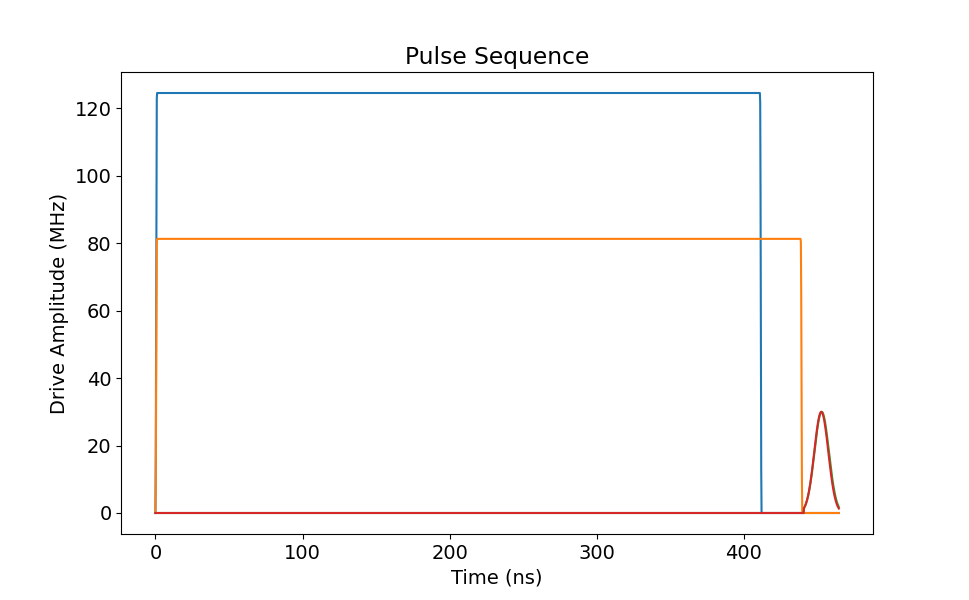

In [299]:
# plot the pulse sequence

envelope_seq = seq.get_envelope_seq()
pulse_amps = seq.get_pulse_amps()
pulse_lens = seq.get_pulse_lengths()
tf = seq.time

times = np.linspace(0, tf, 2000)
flat_times = np.array(times).flatten()

fig, ax = plt.subplots(1, 1)

for i in range(len(envelope_seq)):
    ax.plot(flat_times, [pulse_amps[i]*envelope_seq[i](t)/MHz for t in flat_times], label=f'Pulse {i}')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Drive Amplitude (MHz)')
ax.set_title('Pulse Sequence')


In [300]:
# psi_idx = '++gg'
psi_idx = 'e+gg'
psi0 = psi_init[psi_idx]
result = qram.evolve(psi0, seq, times, c_ops=c_ops_list, nsteps=8000, progress=True)


10.0%. Run time: 107.09s. Est. time left: 00:00:16:03
20.0%. Run time: 227.50s. Est. time left: 00:00:15:09
30.0%. Run time: 347.94s. Est. time left: 00:00:13:31
40.0%. Run time: 468.39s. Est. time left: 00:00:11:42
50.0%. Run time: 588.81s. Est. time left: 00:00:09:48
60.0%. Run time: 709.06s. Est. time left: 00:00:07:52
70.0%. Run time: 829.50s. Est. time left: 00:00:05:55
80.0%. Run time: 989.07s. Est. time left: 00:00:04:07
90.0%. Run time: 1161.12s. Est. time left: 00:00:02:09
Total run time: 1332.97s


In [301]:
result_rot = result
psi_plot = []

for t in [0, len(times)//2,-1]:
    for i in range(cutoffs[0]):
        for j in range(cutoffs[1]):
            for k in range(cutoffs[2]):
                for l in range(cutoffs[3]):
                    psi_ids = [i, j, k, l]
                    psi_str = qram.level_nums_to_name(psi_ids)
                    # print(psi)
                    psi = qram.state(psi_str)
                    ov = np.abs(psi.dag()*result_rot[t]*psi.full())[0][0]
                    if ov > 0.05:
                        psi_plot.append(psi_str)

psi_plot = list(set(psi_plot))

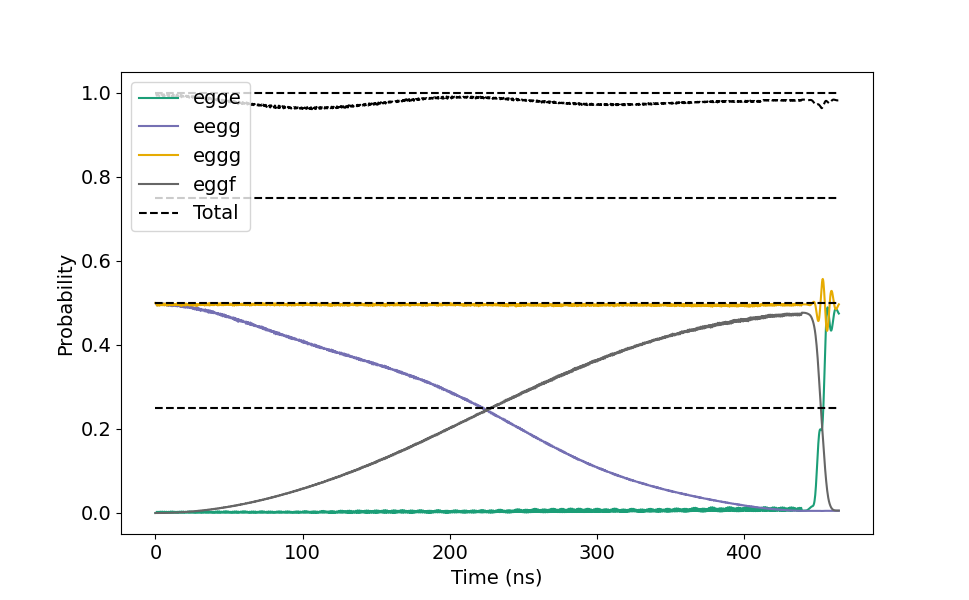

In [302]:
cmap = plt.get_cmap('Dark2')
colors = cmap(np.linspace(0, 1, len(psi_plot)))
figs, axs = plt.subplots(1, 1)

prob_sum = np.zeros(len(times))

for psi in psi_plot:
    state = qram.state(psi)
    prob = [np.abs(state.dag()*result_rot[t]*state.full())[0][0] for t in range(len(times))]
    # prob = [np.abs(state.overlap( result_rot[t]))**2 for t in range(len(times))]
    prob_sum += prob

for psi in psi_plot: 
    state = qram.state(psi)
    # prob = [np.abs(state.dag()*result_rot[t]*state.full()).flatten() for t in range(len(times))]
    prob = [np.abs(state.dag()*result_rot[t]*state.full())[0][0] for t in range(len(times))]
    # prob = [np.abs(state.overlap(result_rot[t]))**2 for t in range(len(times))]



    axs.plot(times, prob, label=psi, color=colors[psi_plot.index(psi)])

axs.plot(times, prob_sum, label='Total', color='black', linestyle='dashed')

axs.hlines(0.5, 0, times[-1], linestyles='dashed', colors='black')
axs.hlines(1, 0, times[-1], linestyles='dashed', colors='black')
axs.hlines(0.25, 0, times[-1], linestyles='dashed', colors='black')
axs.hlines(0.75, 0, times[-1], linestyles='dashed', colors='black')
axs.set_xlabel('Time (ns)')
axs.set_ylabel('Probability')

axs.legend(loc='upper left')

## Compute the evolution of the state with the decay channels

In [303]:
psi_result_decays = {}

for psi in psi_init:
    print(psi)
    result = qram.evolve(psi_init[psi], seq, times, c_ops=c_ops_list, nsteps=8000, progress=True)

    result_rot = result


    psi_result_decays[psi] = result_rot[-1]

gggg


10.0%. Run time: 107.71s. Est. time left: 00:00:16:09
20.0%. Run time: 233.21s. Est. time left: 00:00:15:32
30.0%. Run time: 358.93s. Est. time left: 00:00:13:57
40.0%. Run time: 484.91s. Est. time left: 00:00:12:07
50.0%. Run time: 610.97s. Est. time left: 00:00:10:10
60.0%. Run time: 736.97s. Est. time left: 00:00:08:11
70.0%. Run time: 862.52s. Est. time left: 00:00:06:09
80.0%. Run time: 988.28s. Est. time left: 00:00:04:07
90.0%. Run time: 1114.22s. Est. time left: 00:00:02:03
Total run time: 1237.61s
eggg
10.0%. Run time: 172.80s. Est. time left: 00:00:25:55
20.0%. Run time: 371.31s. Est. time left: 00:00:24:45
30.0%. Run time: 569.04s. Est. time left: 00:00:22:07
40.0%. Run time: 732.52s. Est. time left: 00:00:18:18
50.0%. Run time: 860.83s. Est. time left: 00:00:14:20
60.0%. Run time: 989.16s. Est. time left: 00:00:10:59
70.0%. Run time: 1117.77s. Est. time left: 00:00:07:59
80.0%. Run time: 1245.70s. Est. time left: 00:00:05:11
90.0%. Run time: 1373.03s. Est. time left: 00:00:

# project on the qubits subspaces

In [304]:
# partial trace on the final states to keep only the qubit subspace

U1 = np.zeros((cutoffs[0], cutoffs[0]))
U2 = np.zeros((cutoffs[1], cutoffs[1]))
U3 = np.zeros((cutoffs[2], cutoffs[2]))
U4 = np.zeros((cutoffs[3], cutoffs[3]))

U1[:2, :2] = qt.qeye(2).full()
U2[:2, :2] = qt.qeye(2).full()
U3[:2, :2] = qt.qeye(2).full()
U4[:2, :2] = qt.qeye(2).full()

U1 = qt.Qobj(U1)
U2 = qt.Qobj(U2)
U3 = qt.Qobj(U3)
U4 = qt.Qobj(U4)

U = qt.tensor(U1, U2, U3, U4).full()

zeros = np.argwhere(np.diag(U) == 0).flatten()

psi_result_qubit_decays = {}

for psi in psi_result_decays:
    psi_temp = psi_result_decays[psi].full()

    psi_temp = np.delete(psi_temp, zeros, axis=0)
    psi_temp = np.delete(psi_temp, zeros, axis=1)

    psi_temp = qt.Qobj(psi_temp)
    psi_temp.dims = [[2, 2, 2, 2], [2, 2, 2, 2]]
    psi_result_qubit_decays[psi] = psi_temp


 C:\Users\slab\AppData\Local\Temp\ipykernel_20512\3628480834.py: 8ComplexWarning: Casting complex values to real discards the imaginary part
 C:\Users\slab\AppData\Local\Temp\ipykernel_20512\3628480834.py: 9ComplexWarning: Casting complex values to real discards the imaginary part
 C:\Users\slab\AppData\Local\Temp\ipykernel_20512\3628480834.py: 10ComplexWarning: Casting complex values to real discards the imaginary part
 C:\Users\slab\AppData\Local\Temp\ipykernel_20512\3628480834.py: 11

### Optimize the Z rotations for the ppgg state 

In [305]:

# loop over the rotation angles and compute the fidelities

phi1_vec = np.linspace(0, 2*np.pi, 30)
phi2_vec = np.linspace(0, 2*np.pi, 1)
phi3_vec = np.linspace(0, 2*np.pi, 50)
phi4_vec = np.linspace(0, 2*np.pi, 50)

fidelities_ppgg = np.zeros((len(phi1_vec), len(phi2_vec), len(phi3_vec), len(phi4_vec)))
fidelities_epgg = np.zeros((len(phi1_vec), len(phi2_vec), len(phi3_vec), len(phi4_vec)))
fidelities_pegg = np.zeros((len(phi1_vec), len(phi2_vec), len(phi3_vec), len(phi4_vec)))


for i, phi1 in enumerate(tqdm(phi1_vec)):
    for j, phi2 in enumerate(tqdm(phi2_vec)):
        for k, phi3 in enumerate(phi3_vec):
            for l, phi4 in enumerate(phi4_vec):
                U = Z(phi1, phi2, phi3, phi4)
                psi_rot = U*psi_result_qubit_decays['++gg']*U.dag()
                psi_rot_2 = U*psi_result_qubit_decays['e+gg']*U.dag()
                psi_rot_3 = U*psi_result_qubit_decays['+egg']*U.dag()

                fidelities_ppgg[i, j, k, l] = np.abs(qt.fidelity(psi_rot, psi_f_qubit['++gg']))
                fidelities_epgg[i, j, k, l] = np.abs(qt.fidelity(psi_rot_2, psi_f_qubit['e+gg']))
                fidelities_pegg[i, j, k, l] = np.abs(qt.fidelity(psi_rot_3, psi_f_qubit['+egg']))


 13%|█▎        | 4/30 [00:58<06:17, 14.52s/it]

100%|██████████| 30/30 [07:15<00:00, 14.53s/it]


In [306]:
# sum the fidelities and find the maximum and the corresponding indices

fidelities_sum = fidelities_ppgg + fidelities_epgg + fidelities_pegg
max_fid = np.max(fidelities_sum)/3
max_fid_idx_4q = np.unravel_index(np.argmax(fidelities_sum), fidelities_sum.shape)


print('max fidelity', max_fid)
print('max fidelity indices', max_fid_idx_4q)
print(fidelities_ppgg[max_fid_idx_4q], fidelities_epgg[max_fid_idx_4q], fidelities_pegg[max_fid_idx_4q])

max fidelity 0.967262747599944
max fidelity indices (13, 0, 23, 39)
0.9707540654786467 0.967691982740246 0.9633421945809392


<bound method Axes.legend of <Axes: >>

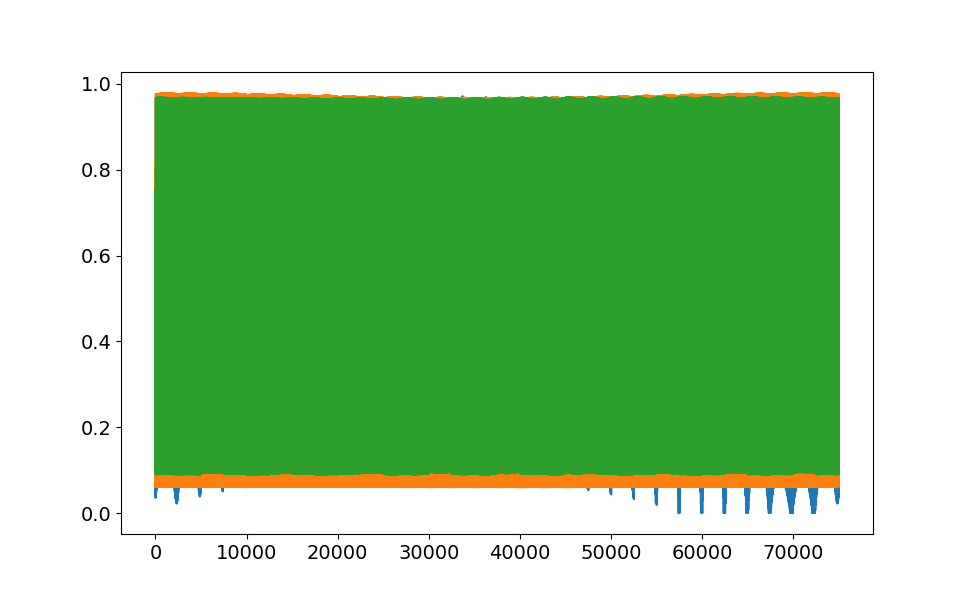

In [307]:
# plot the flatten fidelities
fig, ax = plt.subplots(1, 1)
ax.plot(fidelities_ppgg.flatten(), label='|ppgg>')
ax.plot(fidelities_epgg.flatten(), label='|epgg>')
ax.plot(fidelities_pegg.flatten(), label='|pegg>')

ax.legend

In [308]:
psi_result_qubit_decays_rot = {}

U_best = Z(phi1_vec[max_fid_idx_4q[0]], phi2_vec[max_fid_idx_4q[1]], phi3_vec[max_fid_idx_4q[2]], phi4_vec[max_fid_idx_4q[3]])

for psi in psi_result_qubit_decays:
    
        psi_rot = U_best*psi_result_qubit_decays[psi]*U_best.dag()
        psi_result_qubit_decays_rot[psi] = psi_rot
        

4


 C:\Users\slab\AppData\Local\Temp\ipykernel_20512\3308495072.py: 20UserWarning: The figure layout has changed to tight
 C:\Users\slab\AppData\Local\Temp\ipykernel_20512\3308495072.py: 47

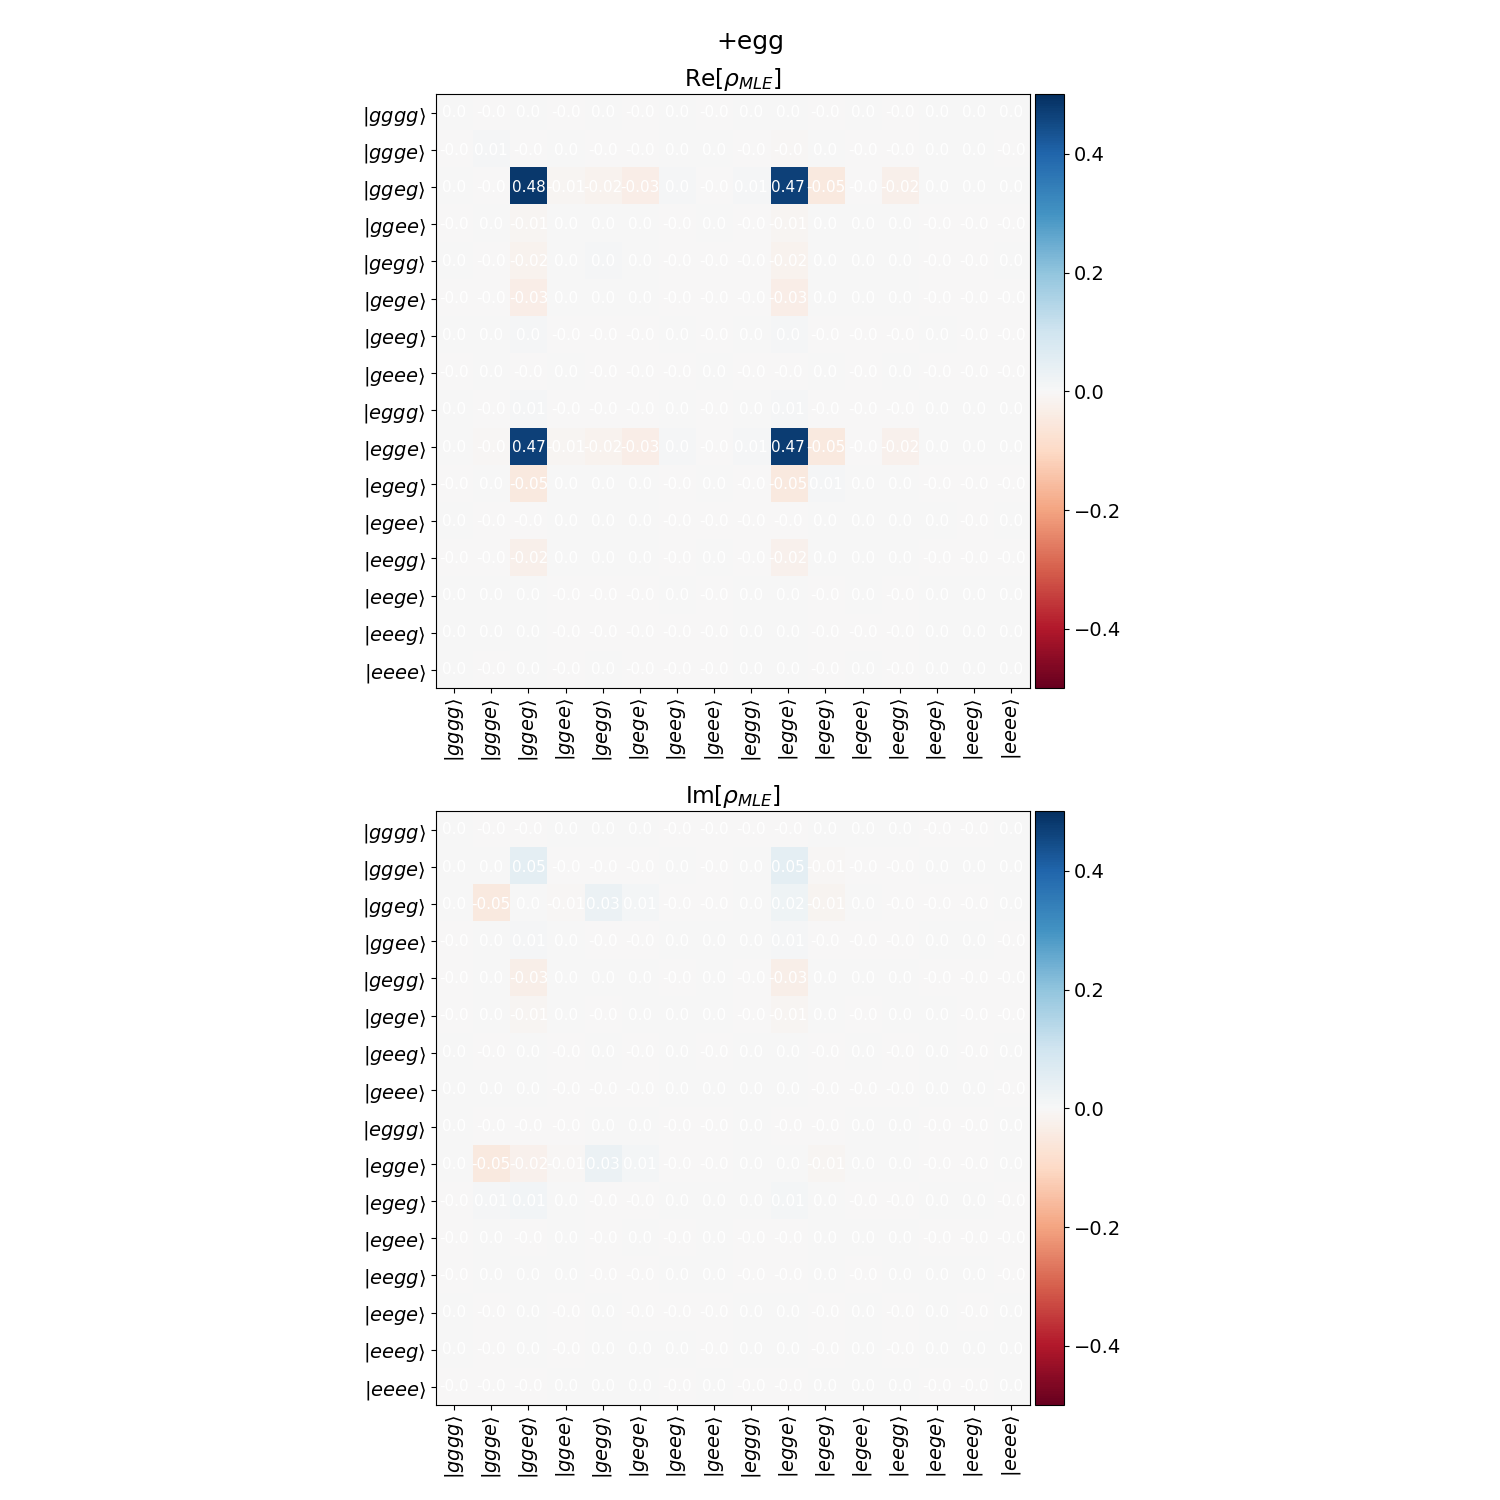

In [309]:
# plot the psi_result_qubit tomography
psi_idx = '+egg'

rho_plot = psi_result_qubit_decays_rot[psi_idx]

show_plot_rho_2d(rho_plot, title=psi_idx, cmax=0.5)

## For all state compute the fidelity with the target state

In [310]:
F_decays = {}

for psi in psi_result_qubit_decays_rot:
    F_decays[psi] = qt.metrics.fidelity(psi_result_qubit_decays_rot[psi], psi_f_qubit[psi])
    

(0.9, 1.05)

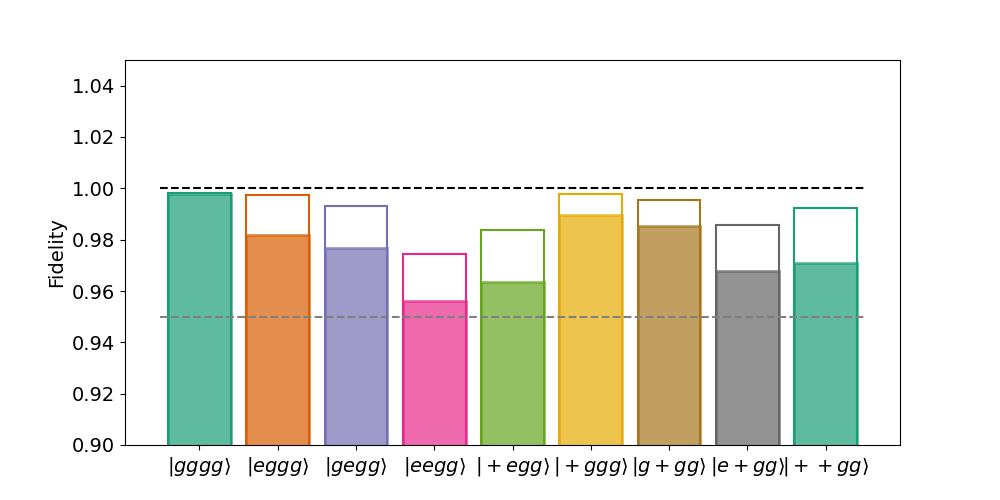

In [311]:
# plot an histogram of the fidelities

# the x label should be the states with a ket notation and vertical 

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

x_list = list(F_decays.keys())

x_labels = [f'$|{x}\\rangle$' for x in x_list]

# use color map Set1

colors = plt.get_cmap('Dark2')(np.linspace(0, 1, len(x_list)-1))

# append a last color

# colors = np.append(colors, plt.get_cmap('tab10')(9), axis=1)

ax.bar(x_labels, F_decays.values(), color=colors, alpha=0.7, edgecolor=colors, linewidth=2)
ax.bar(x_labels, F.values(), color=colors, alpha=1, edgecolor=colors, linewidth=1.5, fill=False)

ax.set_ylabel('Fidelity')

# add a horizontal line at 1

ax.hlines(1, -0.5, len(F_decays)-0.5, linestyles='dashed', colors='black')
ax.hlines(0.95, -0.5, len(F_decays)-0.5, linestyles='dashed', colors='grey')

ax.set_ylim(0.9, 1.05)


# take the 3 qubits partial trace 

In [312]:
psi_result_decay_3Q = {}

for psi in psi_result_decays:

    psi_temp =  psi_result_qubit_decays_rot[psi]
    psi_temp = psi_temp.ptrace([0, 2, 3])
    psi_result_decay_3Q[psi] = psi_temp



In [313]:
F_3Q_decays = {}

for psi in psi_result_decay_3Q:
    F_3Q_decays[psi] = qt.metrics.fidelity(psi_result_decay_3Q[psi], psi_f_3Q[psi])



(0.9, 1.05)

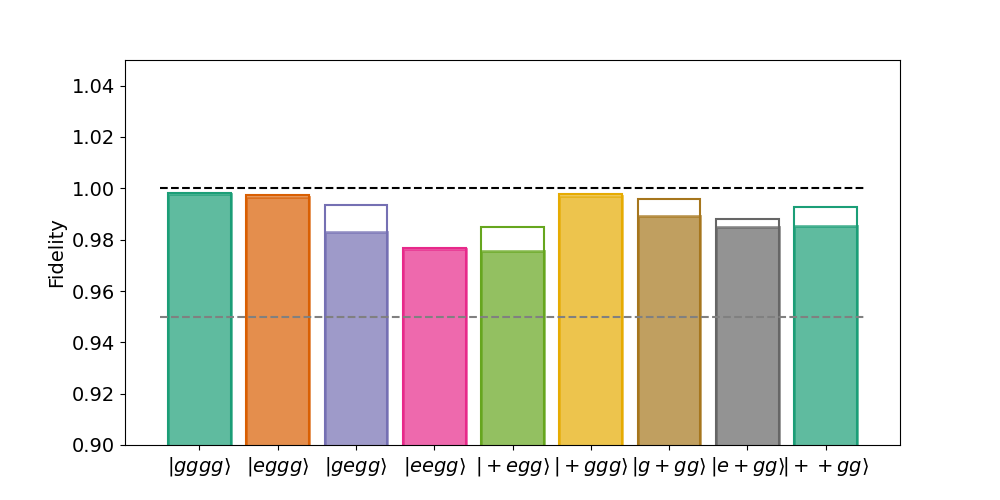

In [314]:
# plot an histogram of the fidelities

# the x label should be the states with a ket notation and vertical

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

x_list = list(F_3Q_decays.keys())

x_labels_3Q = [f'$|{x}\\rangle$' for x in x_list]

colors = plt.get_cmap('Dark2')(np.linspace(0, 1, len(x_list)-1))

ax.bar(x_labels_3Q, F_3Q_decays.values(), color=colors, alpha=0.7, edgecolor=colors, linewidth=2)
ax.bar(x_labels_3Q, F_3Q.values(), color=colors, alpha=1, edgecolor=colors, linewidth=1.5, fill=False)

ax.set_ylabel('Fidelity')

# add a horizontal line at 1

ax.hlines(1, -0.5, len(F_3Q_decays)-0.5, linestyles='dashed', colors='black')   
ax.hlines(0.95, -0.5, len(F_3Q_decays)-0.5, linestyles='dashed', colors='grey')

ax.set_ylim(0.9, 1.05)

# Preparation of the ++ state

In [82]:
seq = PulseSequence(start_time=0)

amp1 = 0.008
amp0 = 0.0005

# Pi/2 on the Q1 
pi2_1 = qram.get_wd('gggg', 'gegg', amp=amp1, drive_qubit=1, verbose=False, phase=-np.pi/2)
qram.add_sequential_pi_pulse(seq, 'gggg', 'gegg', drive_qubit=1, amp=amp1, type='gauss', t_offset=0, wd=pi2_1, sigma_n=4, pihalf=True, phase=-np.pi/2)


pi3_e = qram.get_wd('eegg', 'gegg', amp=amp0, drive_qubit=0, verbose=False)
pi3_g = qram.get_wd('eggg', 'gggg', amp=amp0, drive_qubit=0, verbose=False)
qram.add_sequential_pi_pulse(seq, 'eegg', 'gegg', drive_qubit=0, amp=amp0, phase=-np.pi/2, type='gauss', t_offset=0, wd=pi3_e, sigma_n=4, pihalf=True)
qram.add_sequential_pi_pulse(seq, 'eggg', 'gggg', drive_qubit=0, amp=amp0, phase=-np.pi/2, type='gauss', t_offset=0, wd=pi3_g, sigma_n=4, pihalf=True)

1
One photon transition
One qubit gate
21.627253178424127
True
1
One photon transition
One qubit gate
1
One photon transition
One qubit gate
25.858340399956735
True
25.89098952418685
True


25.89098952418685

Text(0.5, 1.0, 'Pulse Sequence')

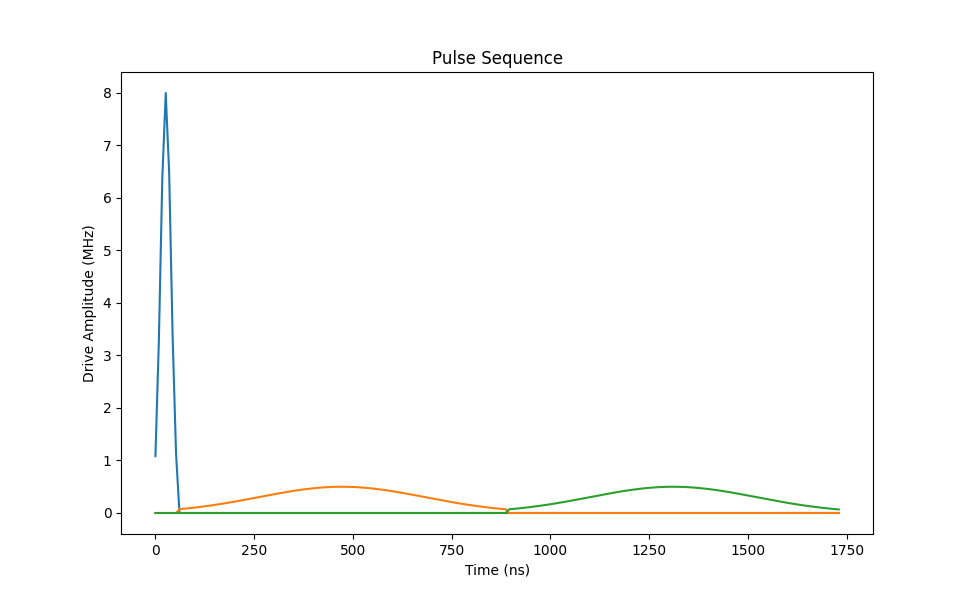

In [83]:
# plot the pulse sequence

envelope_seq = seq.get_envelope_seq()
pulse_amps = seq.get_pulse_amps()
pulse_lens = seq.get_pulse_lengths()
tf = seq.time

times = np.linspace(0, tf, 200)
flat_times = np.array(times).flatten()

fig, ax = plt.subplots(1, 1)

for i in range(len(envelope_seq)):
    ax.plot(flat_times, [pulse_amps[i]*envelope_seq[i](t)/MHz for t in flat_times], label=f'Pulse {i}')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Drive Amplitude (MHz)')
ax.set_title('Pulse Sequence')

In [84]:

psi0 = psi_init['gggg']
result = qram.evolve(psi0, seq, times, c_ops=None, nsteps=10000, progress=False)
rotating_frame = True 

if rotating_frame:

    result_rot = [0*result[i_t] for i_t in range(len(times))]
    evals, evecs = qram.esys

    for i_t, t in enumerate(tqdm(times)):
        for eval, evec in zip(evals, evecs):
            result_rot[i_t] += np.exp(1j*eval*t) * evec.overlap(result[i_t]) * evec

else:

    result_rot = result

# pick up the relevant states for the protocol 

psi_plot = []

for t in [0, 2*len(times)//3,-1]:
    for i in range(cutoffs[0]):
        for j in range(cutoffs[1]):
            for k in range(cutoffs[2]):
                for l in range(cutoffs[3]):
                    psi_ids = [i, j, k, l]
                    psi = qram.level_nums_to_name(psi_ids)
                    # print(psi)
                    ov = np.abs(result_rot[t].overlap(qram.state(psi)))
                    if ov > 0.05:
                        print(psi, ov)
                        psi_plot.append(psi)

psi_plot = list(set(psi_plot))

100%|██████████| 200/200 [00:05<00:00, 39.60it/s]


gggg 1.0
gggg 0.6984595090150587
gegg 0.4936682959184411
eggg 0.11421383895499887
eegg 0.505343320081741
gggg 0.5050196135149077
gegg 0.49772444064664056
eggg 0.4959031294620176
eegg 0.501275197162657


Quantum object: dims = [[3, 3, 4, 4], [1, 1, 1, 1]], shape = (144, 1), type = ket
Qobj data =
[[ 0.        ]
 [-0.04671663]
 [ 0.        ]
 [ 0.        ]
 [-0.04154095]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.99491907]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.07891737]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0. 

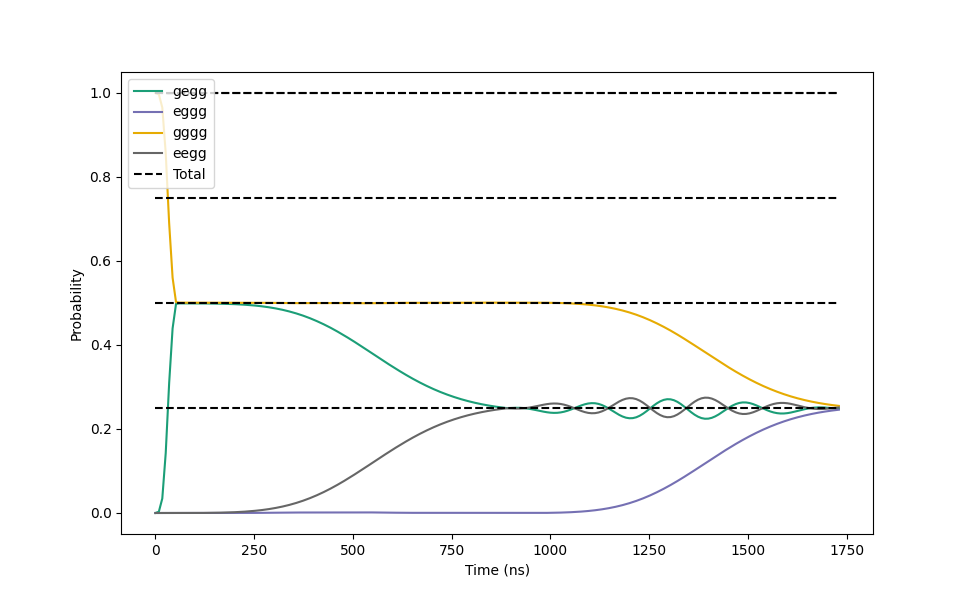

In [85]:
cmap = plt.get_cmap('Dark2')
colors = cmap(np.linspace(0, 1, len(psi_plot)))
figs, axs = plt.subplots(1, 1)

prob_sum = np.zeros(len(times))

for psi in psi_plot:
    state = qram.state(psi)
    prob = [np.abs(state.overlap(result_rot[t]))**2 for t in range(len(times))]
    prob_sum += prob

for psi in psi_plot: 
    state = qram.state(psi)
    print(state)
    print(result_rot[0])

    # prob = [np.abs(state.dag()*result_rot[t]*state.full()).flatten() for t in range(len(times))]
    prob = [np.abs(state.overlap(result_rot[t]))**2 for t in range(len(times))]

    axs.plot(times, prob, label=psi, color=colors[psi_plot.index(psi)])

axs.plot(times, prob_sum, label='Total', color='black', linestyle='dashed')

axs.hlines(0.5, 0, times[-1], linestyles='dashed', colors='black')
axs.hlines(1, 0, times[-1], linestyles='dashed', colors='black')
axs.hlines(0.25, 0, times[-1], linestyles='dashed', colors='black')
axs.hlines(0.75, 0, times[-1], linestyles='dashed', colors='black')
axs.set_xlabel('Time (ns)')
axs.set_ylabel('Probability')

axs.legend(loc='upper left')

2


 C:\Users\slab\AppData\Local\Temp\ipykernel_18552\3308495072.py: 20UserWarning: The figure layout has changed to tight
 C:\Users\slab\AppData\Local\Temp\ipykernel_18552\3308495072.py: 47

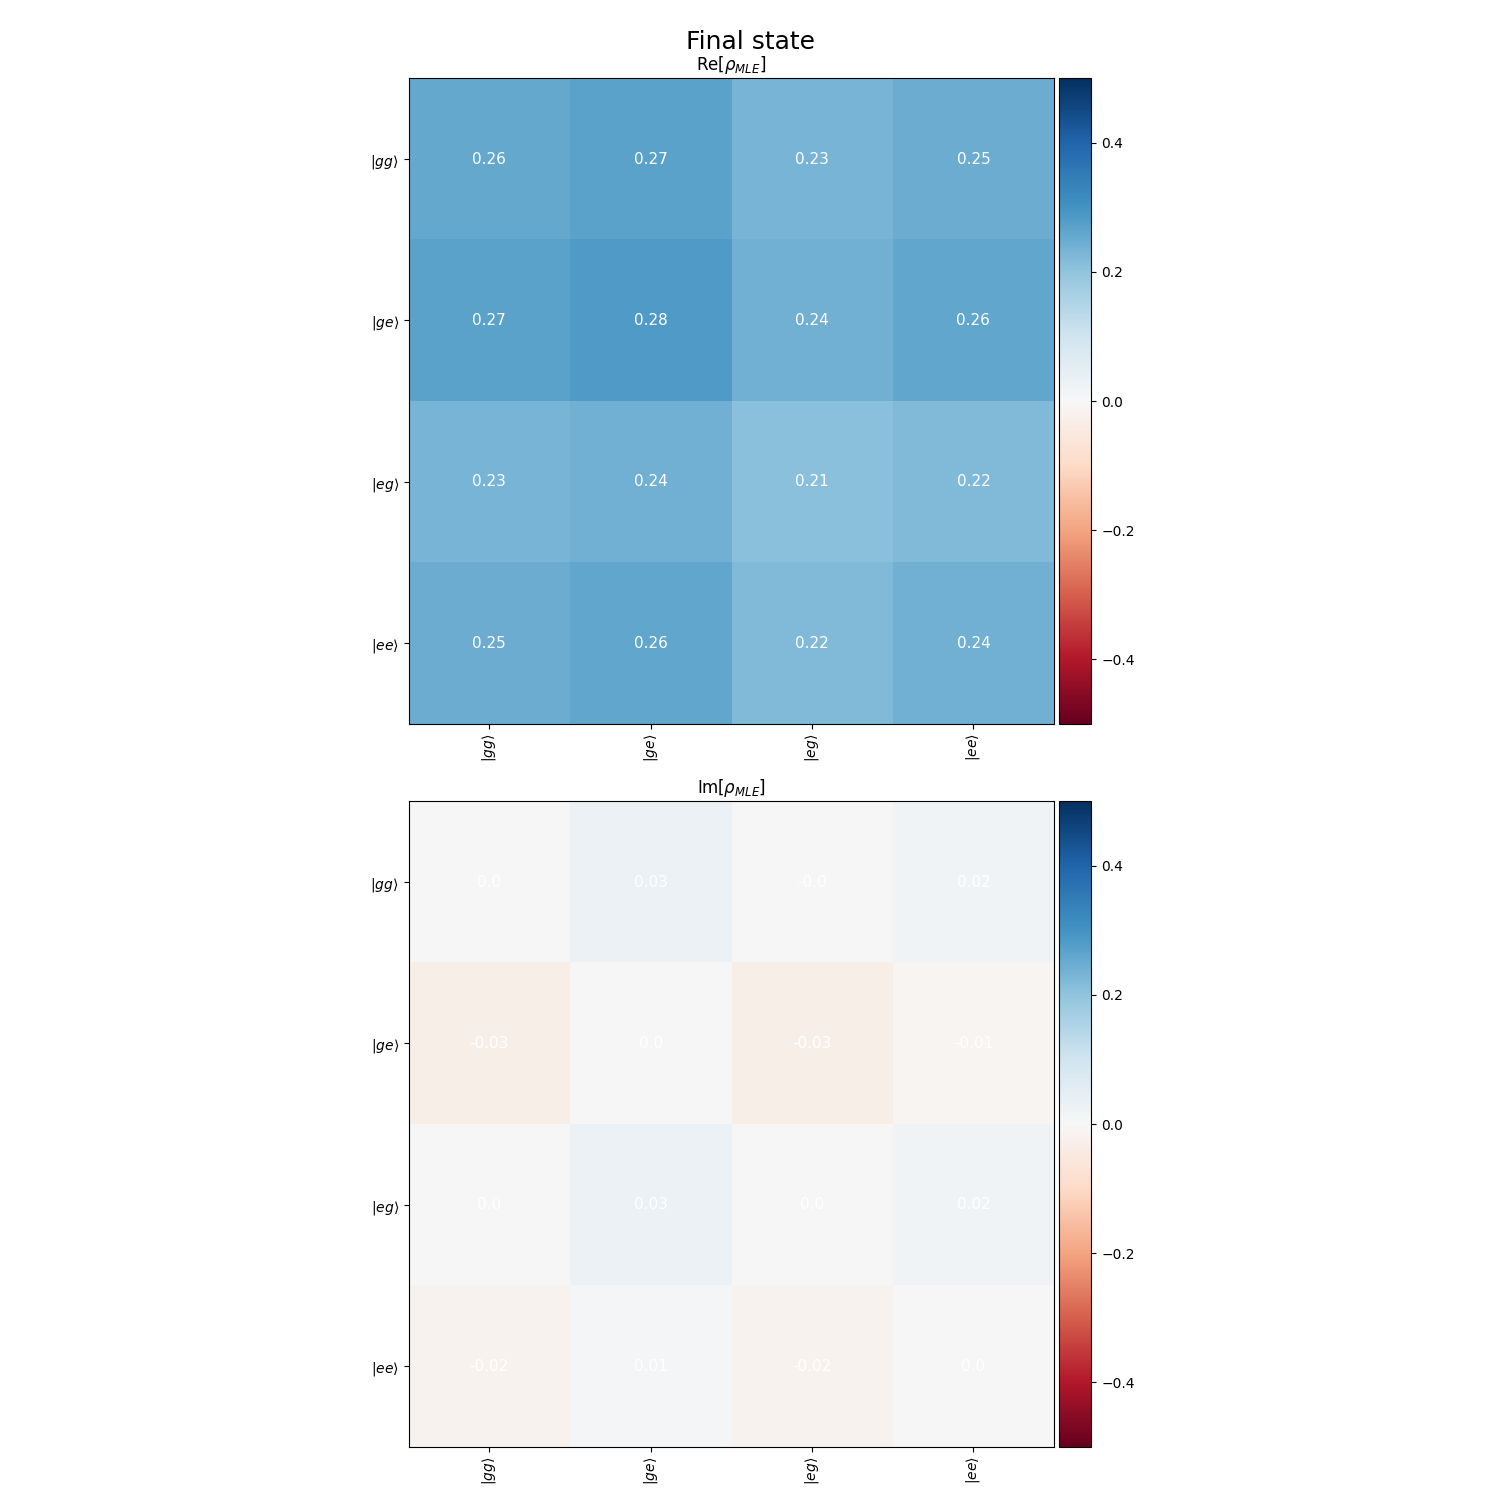

In [86]:
# take the qubit subspace
psi_plot = result_rot[-1].full()[zeros]
psi_plot = qt.Qobj(psi_plot)
psi_plot.dims = [[2, 2, 2, 2], [1, 1, 1, 1]]

# plot the psi_result_qubit tomography

# rho_plot = psi_plot*psi_plot.dag()
# rho_plot = psi_plot*psi_plot.dag()

rho_plot = psi_plot.ptrace([0, 1])

show_plot_rho_2d(rho_plot, title='Final state', cmax=0.5)

